# USS Pension Scheme calculations
Notebook to analyse benefits/returns from the proposed USS scheme from April 2024 and compare with those from a self-invested personal pension (SIPP) and the current scheme, as a function of salary and age.

This notebook runs python 3 code.

In [1]:
#Note book setup

#enables autosaving every 30s. Change "30" to "0" to disable autosaving.
%autosave 30

#use inline interactive plots
%matplotlib notebook

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numbers

Autosaving every 30 seconds


## Introduction

The USS scheme has two main parts: a defined benefit (DB) part that promises a certain payment in retirement plus a cash lump sum, and a defined contribution (DC) part where payments in are invested and the amount available in retirement is the value of these investments at that time. There is no option about which to pay into - salary below a threshold is paid into the defined benefit part and salary above goes to the defined contribution part. 

For comparison, I consider the expected return for someone paying their USS contribution into a self-invested personal pension (SIPP) instead (not getting the employer contribution or national insurance relief), and buying an inflation-linked annuity at retirement age (for comparability with getting a pension from USS). 

For both the USS DC part and SIPP investor, I consider someone using a fairly "moderate" 60% stocks/40% government bond portfolio and someone invested for "high growth" in 100% equities. Note the actual return may differ substantially from the expected return and this isn't considered. (The DC fund options include 100% equities funds and other mixed asset or bond funds, and a 60% stocks/40% bond portfolio's expected return should sit somewhere in the range of expected returns from these funds, but doesn't correspond to any one in particular.) The USS DC part is assumed to grow at the same rate as investments into the SIPP and have the same charges (but benefit from having the added employer contribution and NI relief). Assuming constant asset allocation through to retirement age is a simplification and results are just meant to be illustrative.

For ease of comparison, the USS DB cash lump sum and USS DC parts are assumed to be used to purchase a single lifetime inflation-linked annuity for someone at retirement age.

All amounts are given in units of current total salary (i.e. the payments that would be expected for each £1 of salary earnt) in inflation-adjusted terms. For simplicity it is assumed that all future USS DB payments increase following inflation, approximating that the inflation caps do not come into play.

## Calculation parameters

In [2]:
#Proposed new scheme parameters, based on those on 4/11/23 at https://ussconsultation2023.co.uk/members/proposals and https://www.uss.co.uk/about-us/valuation-and-funding/2023-valuation?search=dfd34ed6-8d04-4d45-a0ec-1af00a3b1f2a
uss_new = { 
    'db_cont':     0.061,       #contribution rate for DB scheme, 6.1%. It is assumed this will stay the same for the DC part, but it's not confirmed, and it seems optimistic to think the employer contribution to the DC part would increase to 13.9%.
    'db_pens':     1/75.,       #fraction of salary paid as pension
    'db_cash':     3/75.,       #fraction of salary that can be taken as lump sum cash
    'db_empl':     0.145,       #employer contribution rate for DB scheme
    'dc_cont':     0.061,       #contribution rate for DC scheme.
    'dc_amount':   0.2,         #amount paid into defined contribution scheme (proposed to stay at 20% of salary, though this is not confirmed)
    'sal_thres':   70308        #salary threshold for changing from defined benefit to defined contribution
}

#Old scheme parameters
uss_old = {
    'db_cont':     0.098,
    'db_pens':     1/85.,
    'db_cash':     3/85.,
    'dc_cont':     0.098,
    'dc_amount':   0.2,
    'sal_thres':   41004     #the 2023/4 value from https://www.uss.co.uk/glossary#Glossary_S
}


#DC/personal pension parameters

#Future expected asset returns set to those used by USS at 31 March 2023 (https://twitter.com/MikeOtsuka/status/1724391242476208397), minus 0.1% assumed investment charge for equities and bonds
eq_exp_growth =    0.040   #expected real equities growth
bonds_exp_growth = 0.005   #expected real government bonds growth
cash_exp_growth = 0.007    #expected real cash growth

#Portfolio compositions
port_hg={'eq': 1.0, 'bonds': 0.0, 'cash': 0.0}  #high-growth - 100% equities
port_mod={'eq': 0.6, 'bonds': 0.4, 'cash': 0.0}  #moderate growth - 60/40 equities/bonds
port_lr={'eq': 0.4, 'bonds': 0.35, 'cash': 0.25}  #low risk - very loosely modelled on USS Default Lifestyle option at retirement date (50% Cautious Growth Fund (~50% high growth, ~50% bonds), 25% Moderate Growth Fund (~70% high growth, ~30% bonds), 25% Liquidity Fund (~100% "cash"), from "A guide to investing in the Investment Builder" (April 2023) and "Quarterly Investment Report for the Investment Builder" (June 2023)).

for port in [port_hg,port_mod,port_lr]:  #checking portfolio fractions sum to 1
    assert abs(np.sum(list(port.values()))-1)<1e-6
    
annuity_yield = 0.049      #best quote from https://www.moneyadviceservice.org.uk/en/tools/annuities for present single lifetime RPI-adjusted annuity for healthy 68 year old on 17/11/23. The best quote for a joint pension paying 50% to a surviving spouse (similar to USS) was 4.4%.

## Estimating expected future pension
By no. of years until retirement, per £ of salary.

### Function definitions

In [3]:
#Function to calculate growth of £1 of invested assets (for USS DC/personal pension investments):
#port - portfolio, a dictionary with keys 'eq', 'bonds' and 'cash' and corresponding values giving the fraction (0 to 1) of the portfolio allocated to equities, bonds and cash.
#n - no. of years until retirement
#derisk - set to True to steadily move portfolio into low risk allocation from the start of the 10th pre-retirement year, following a linear change in allocation over time
def investment_value(port,n,derisk=False):
    assert abs(np.sum(list(port.values()))-1)<1e-6
    
    """return port['eq']*(1+eq_exp_growth)**n + port['bonds']*(1+bonds_exp_growth)**n + port['cash']*(1+cash_exp_growth)**n"""
    
    mean_growth = port['eq']*eq_exp_growth + port['bonds']*bonds_exp_growth + port['cash']*cash_exp_growth
    
    if not derisk:
        vals=(1+mean_growth)**n
    else:

        #Check if n is iterable, and if not (because it's one number), then make it a list.
        try:
            n.__iter__
        except:
            n=[n]

        vals=np.zeros(len(n))

        for i,n_temp in enumerate(n):

            derisk_time=10  #no. of years over which to derisk
            n_pre_derisk=n_temp-derisk_time

            if n_pre_derisk>0:
                vals[i]=(1+mean_growth)**n_pre_derisk
            else:
                vals[i]=1

            port_temp=port
            min_t_to_retirement=min(n_temp,derisk_time)
            #print(i, n_temp, port_temp, mean_growth, vals[i])  #testing
            for t in range(derisk_time-min_t_to_retirement+1,derisk_time+1):
                if derisk:
                    port_temp={
                        'eq': ((derisk_time-t)*port['eq']+t*port_lr['eq'])/derisk_time,
                        'bonds': ((derisk_time-t)*port['bonds']+t*port_lr['bonds'])/derisk_time,
                        'cash': ((derisk_time-t)*port['cash']+t*port_lr['cash'])/derisk_time,
                    }
                else:
                    port_temp=port

                mean_growth_temp = port_temp['eq']*eq_exp_growth + port_temp['bonds']*bonds_exp_growth + port_temp['cash']*cash_exp_growth
                #print(i, n_temp, t, port_temp, mean_growth_temp, vals[i], vals[i]*(1+mean_growth_temp))  #testing
                vals[i]*=(1+mean_growth_temp)
    
    #print(vals)  #testing
    return vals
    
#USS lump sum annuity purchase
#uss_params is either uss_new or uss_old from above
def uss_ls(uss_params):
    return uss_params['db_cash']*annuity_yield

#USS DC part. 
#salary arg is in £
#Returns:
#pens_dc - pension per unit invested into DC scheme
#dc_frac - fraction of employee salary invested in DC scheme, including employer contribution
def uss_dc(uss_params,salary,port,n,derisk=False):
    pens_dc = investment_value(port,n,derisk=derisk)*annuity_yield
    dc_frac = uss_params['dc_amount']*max(0, (salary-uss_params['sal_thres'])/salary)
    return pens_dc, dc_frac
    
#Fraction of employee salary invested in DB scheme
def uss_db_frac(uss_params,salary):
    return uss_params['db_cont']*min(1,uss_params['sal_thres']/salary)
    
#USS total
#Set scale_by_inv_return to True to scale the DB part by the investment return that would be expected if the contributions were invested in the DC scheme. This is normalised to have the same integral as if it were unscaled over the range of years in n if n is not a single number, else over year range 1-40.
def uss_pens(uss_params,salary,port=None,n=None,derisk=False,scale_by_inv_return=False):
    
    pens_db = (uss_params['db_pens'] + uss_ls(uss_params))*min(1,uss_params['sal_thres']/salary)  #contribution from salary up to salary threshold
    
    if scale_by_inv_return:
        pens_db_scaled=pens_db*investment_value(port,n)
        
        #normalise to have same integral with respect to years to retirement as unadjusted values
        if isinstance(n, numbers.Number):  #if n is a single value, use year range 1-40
            yrs=np.arange(40)+1
            pens_db_norm_factor=np.trapz(pens_db*investment_value(port,yrs), x=yrs)
            pens=pens_db_scaled*np.trapz(pens_db*np.ones(len(yrs)), x=yrs)/pens_db_norm_factor
            #print('n is number')  #testing
            #print(pens, np.trapz(pens_db*np.ones(len(yrs)), x=yrs), pens_db_norm_factor)
        else:  #else, use given year range
            pens=pens_db_scaled*np.trapz(pens_db*np.ones(len(n)), x=n)/np.trapz(pens_db_scaled, x=n)  
            #print('n is not a number')
            #print(pens[29], np.trapz(pens_db*np.ones(len(n)), x=n), np.trapz(pens_db_scaled, x=n))
    else:
        pens=pens_db
    
    if salary > uss_params['sal_thres']:
        assert port is not None and n is not None
        pens_dc, dc_frac = uss_dc(uss_params,salary,port,n,derisk=derisk)
        pens += pens_dc*dc_frac
    
    return pens

#USS cost as fraction of salary
def uss_cost(uss_params,salary):
    db_frac=uss_db_frac(uss_params,salary)
    dc_frac=uss_params['dc_cont']*max(0, (salary-uss_params['sal_thres'])/salary)  #employee DC contribution as fraction of salary
    return db_frac+dc_frac

#Equivalent DC pension if USS DB contributions were paid into DC scheme
def uss_dc_equiv(uss_params,port=None,n=None,derisk=False):
    pens_dc, _ = uss_dc(uss_params, 1, port, n, derisk=derisk)  #salary argument is irrelevant
    pens=pens_dc*(uss_params['db_cont']+uss_params['db_empl'])
    return pens


#SIPP pension estimate 

#National insurance
def ni(salary):
    x = 0.12*max(0,min(50270-12570, salary-12570)) + 0.02*max(0,salary-50270)
    return x/salary

#SIPP pension
#Set sub_ni=True to subtract national insurance (default)
#Set add_ec=True to add employer DB contribution
def sipp_pens(uss_params,salary,port,n,sub_ni=True,add_ec=False,derisk=False):
    pens_cont=uss_cost(uss_params,salary)  #total pension contribution
    if sub_ni:
        pens_cont*=(1-ni(salary))
    if add_ec:
        pens_cont+=uss_params['db_empl']
    
    return pens_cont*investment_value(port,n,derisk=derisk)*annuity_yield


### Pension estimates

For salaries of £40k (representative of any salaries below the current salary threshold) and £65k (just below the new salary threshold).

In [4]:
#Pensions as function of years to retirement for salaries of £40k (representative of any salaries below the current salary threshold) and £65k (just below the new salary threshold)

yrs=np.arange(40)+1  #consider no. of years to retirement between 1-40

pens_40k = {
    'uss_new':      np.array([uss_pens(uss_new, 40000)]*len(yrs)),
    'uss_new':      np.array([uss_pens(uss_new, 40000)]*len(yrs)),
    'uss_old':      np.array([uss_pens(uss_old, 40000)]*len(yrs)),
    'uss_cost_new': uss_cost(uss_new, 40000), 
    'uss_cost_old': uss_cost(uss_old, 40000),
    'sipp_mod':     sipp_pens(uss_new, 40000, port_mod, yrs),  #moderate equities allocation
    'sipp_mod_dr':     sipp_pens(uss_new, 40000, port_mod, yrs, derisk=True),  #as above, with derisking in last 10 years of retirement
    'sipp_hg':     sipp_pens(uss_new, 40000, port_hg, yrs),   #high-growth equities allocation
    'sipp_hg_dr':     sipp_pens(uss_new, 40000, port_hg, yrs, derisk=True),
    'uss_new_dc_equiv_mod': uss_dc_equiv(uss_new, port_mod, yrs),  #expected value of DC scheme if all DB scheme contributions were paid into that
    'uss_new_dc_equiv_mod_dr': uss_dc_equiv(uss_new, port_mod, yrs, derisk=True),
    'uss_new_dc_equiv_hg': uss_dc_equiv(uss_new, port_hg, yrs),
    'uss_new_dc_equiv_hg_dr': uss_dc_equiv(uss_new, port_hg, yrs, derisk=True),
    'uss_new_db_scaled_mod':      uss_pens(uss_new, 40000, port_mod, yrs, scale_by_inv_return=True),  #scaling DB part by expected investment return
    'uss_new_db_scaled_hg':      uss_pens(uss_new, 40000, port_hg, yrs, scale_by_inv_return=True),
}

pens_65k = {
    'uss_new_mod':  np.array([uss_pens(uss_new, 65000, port_mod, yrs)]*len(yrs)),
    'uss_new_hg':  np.array([uss_pens(uss_new, 65000, port_hg, yrs)]*len(yrs)),
    'uss_old_mod':  uss_pens(uss_old, 65000, port_mod, yrs),
    'uss_old_mod_dr':  uss_pens(uss_old, 65000, port_mod, yrs, derisk=True),
    'uss_old_hg':  uss_pens(uss_old, 65000, port_hg, yrs),
    'uss_old_hg_dr':  uss_pens(uss_old, 65000, port_hg, yrs, derisk=True),
    'uss_cost_new': uss_cost(uss_new, 65000), 
    'uss_cost_old': uss_cost(uss_old, 65000),
    'sipp_mod':     sipp_pens(uss_new, 65000, port_mod, yrs),
    'sipp_mod_dr':     sipp_pens(uss_new, 65000, port_mod, yrs, derisk=True),
    'sipp_hg':     sipp_pens(uss_new, 65000, port_hg, yrs),
    'sipp_hg_dr':     sipp_pens(uss_new, 65000, port_hg, yrs, derisk=True),
    'uss_new_db_scaled_mod':      uss_pens(uss_new, 65000, port_mod, yrs, scale_by_inv_return=True),
    'uss_new_db_scaled_hg':      uss_pens(uss_new, 65000, port_hg, yrs, scale_by_inv_return=True),
}



#Getting pensions as function of salary for fixed time to retirement
salaries=np.arange(20,101,1)*1000

pens_10yrs = {
    'uss_new_mod':  np.zeros((len(salaries),)),
    'uss_new_mod_dr':  np.zeros((len(salaries),)),
    'uss_new_hg':  np.zeros((len(salaries),)),
    'uss_new_hg_dr':  np.zeros((len(salaries),)),
    'uss_old_mod':  np.zeros((len(salaries),)),
    'uss_old_mod_dr':  np.zeros((len(salaries),)),
    'uss_old_hg':  np.zeros((len(salaries),)),
    'uss_old_hg_dr':  np.zeros((len(salaries),)),
    'uss_new_mod_scaled':  np.zeros((len(salaries),)),
    'uss_new_hg_scaled':  np.zeros((len(salaries),)),
}

pens_30yrs = {
    'uss_new_mod':  np.zeros((len(salaries),)),
    'uss_new_mod_dr':  np.zeros((len(salaries),)),
    'uss_new_hg':  np.zeros((len(salaries),)),
    'uss_new_hg_dr':  np.zeros((len(salaries),)),
    'uss_old_mod':  np.zeros((len(salaries),)),
    'uss_old_mod_dr':  np.zeros((len(salaries),)),
    'uss_old_hg':  np.zeros((len(salaries),)),
    'uss_old_hg_dr':  np.zeros((len(salaries),)),
    'uss_new_mod_scaled':  np.zeros((len(salaries),)),
    'uss_new_hg_scaled':  np.zeros((len(salaries),)),
}

pens_cost_new=np.zeros((len(salaries),))
pens_cost_old=np.zeros((len(salaries),))

for i,sal in enumerate(salaries):
    pens_10yrs['uss_new_mod'][i] = uss_pens(uss_new, sal, port_mod, 10)
    pens_10yrs['uss_new_mod_dr'][i] = uss_pens(uss_new, sal, port_mod, 10, derisk=True)
    pens_10yrs['uss_new_hg'][i] = uss_pens(uss_new, sal, port_hg, 10)
    pens_10yrs['uss_new_hg_dr'][i] = uss_pens(uss_new, sal, port_hg, 10, derisk=True)
    pens_10yrs['uss_old_mod'][i] = uss_pens(uss_old, sal, port_mod, 10)
    pens_10yrs['uss_old_mod_dr'][i] = uss_pens(uss_old, sal, port_mod, 10, derisk=True)
    pens_10yrs['uss_old_hg'][i] = uss_pens(uss_old, sal, port_hg, 10)
    pens_10yrs['uss_old_hg_dr'][i] = uss_pens(uss_old, sal, port_hg, 10, derisk=True)
    pens_10yrs['uss_new_mod_scaled'][i] = uss_pens(uss_new, sal, port_mod, 10, scale_by_inv_return=True)
    pens_10yrs['uss_new_hg_scaled'][i] = uss_pens(uss_new, sal, port_hg, 10, scale_by_inv_return=True)
    
    pens_30yrs['uss_new_mod'][i] = uss_pens(uss_new, sal, port_mod, 30)
    pens_30yrs['uss_new_mod_dr'][i] = uss_pens(uss_new, sal, port_mod, 30, derisk=True)
    pens_30yrs['uss_new_hg'][i] = uss_pens(uss_new, sal, port_hg, 30)
    pens_30yrs['uss_new_hg_dr'][i] = uss_pens(uss_new, sal, port_hg, 30, derisk=True)
    pens_30yrs['uss_old_mod'][i] = uss_pens(uss_old, sal, port_mod, 30)
    pens_30yrs['uss_old_mod_dr'][i] = uss_pens(uss_old, sal, port_mod, 30, derisk=True)
    pens_30yrs['uss_old_hg'][i] = uss_pens(uss_old, sal, port_hg, 30)
    pens_30yrs['uss_old_hg_dr'][i] = uss_pens(uss_old, sal, port_hg, 30, derisk=True)
    pens_30yrs['uss_new_mod_scaled'][i] = uss_pens(uss_new, sal, port_mod, 30, scale_by_inv_return=True)
    pens_30yrs['uss_new_hg_scaled'][i] = uss_pens(uss_new, sal, port_hg, 30, scale_by_inv_return=True)
    
    pens_cost_new[i]             = uss_cost(uss_new, sal)
    pens_cost_old[i]             = uss_cost(uss_old, sal)

### Pension values vs years to retirement


<IPython.core.display.Javascript object>


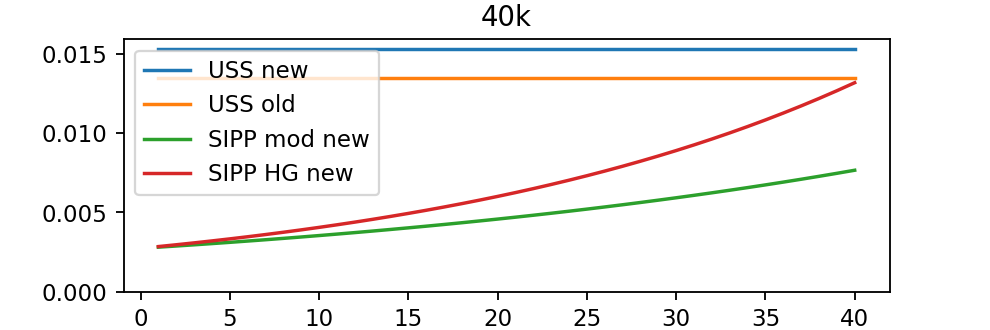

<IPython.core.display.Javascript object>


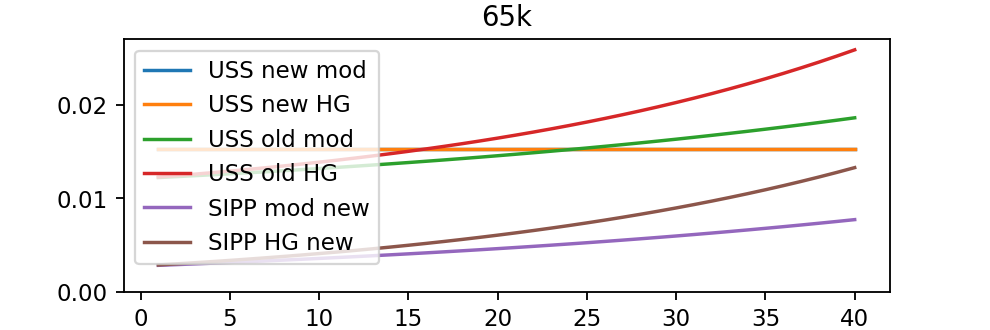

In [5]:
#40k salary
plt.figure(figsize=(6,2))
plt.title('40k')
plt.plot(yrs, pens_40k['uss_new'], label='USS new')
plt.plot(yrs, pens_40k['uss_old'], label='USS old')
plt.plot(yrs, pens_40k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_40k['sipp_hg'], label='SIPP HG new')
plt.ylim(ymin=0)
plt.legend()

#65k salary
plt.figure(figsize=(6,2))
plt.title('65k')
plt.plot(yrs, pens_65k['uss_new_mod'], label='USS new mod')
plt.plot(yrs, pens_65k['uss_new_hg'], label='USS new HG')
plt.plot(yrs, pens_65k['uss_old_mod'], label='USS old mod')
plt.plot(yrs, pens_65k['uss_old_hg'], label='USS old HG')
plt.plot(yrs, pens_65k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_65k['sipp_hg'], label='SIPP HG new')
plt.ylim(ymin=0)
plt.legend()

#### Effect of derisking in decade before retirement

<IPython.core.display.Javascript object>


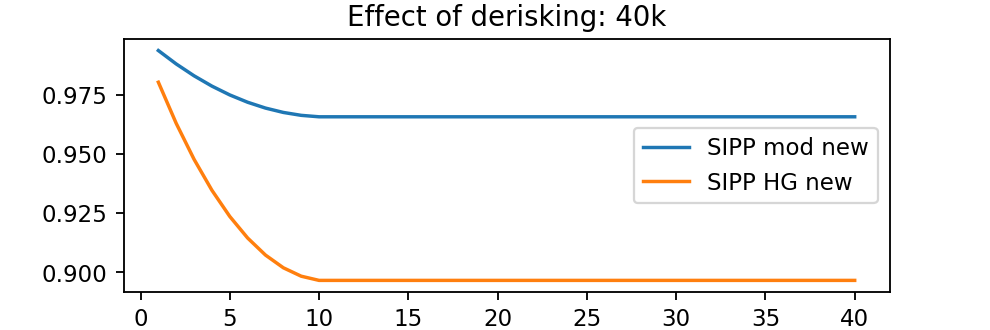

<IPython.core.display.Javascript object>

In [6]:
plt.figure(figsize=(6,2))
plt.title('Effect of derisking: 40k')
plt.plot(yrs, pens_40k['sipp_mod_dr']/pens_40k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_40k['sipp_hg_dr']/pens_40k['sipp_hg'], label='SIPP HG new')
plt.xlabel('Years to retirement')
plt.legend()

#65k salary
plt.figure(figsize=(6,2))
plt.title('Effect of derisking: 65k')
plt.plot(yrs, pens_65k['uss_old_mod_dr']/pens_65k['uss_old_mod'], label='USS old mod')
plt.plot(yrs, pens_65k['uss_old_hg_dr']/pens_65k['uss_old_hg'], label='USS old HG')
plt.plot(yrs, pens_65k['sipp_mod_dr']/pens_65k['sipp_mod'], label='SIPP mod new')
plt.plot(yrs, pens_65k['sipp_hg_dr']/pens_65k['sipp_hg'], label='SIPP HG new')
plt.xlabel('Years to retirement')
plt.legend()

### Pension values as ratio of cost vs years to retirement

<IPython.core.display.Javascript object>


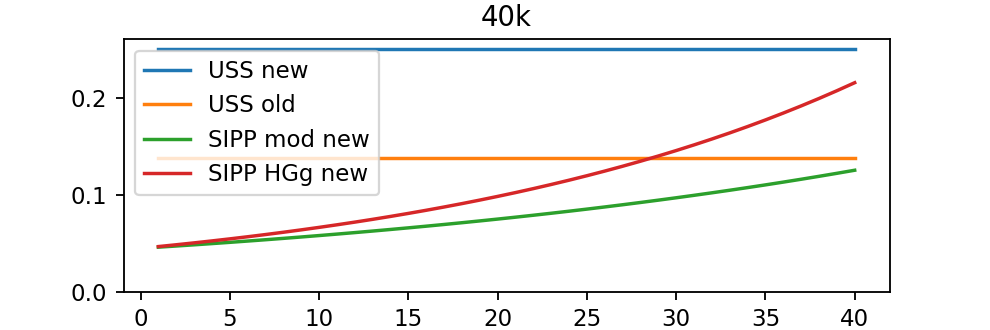

<IPython.core.display.Javascript object>


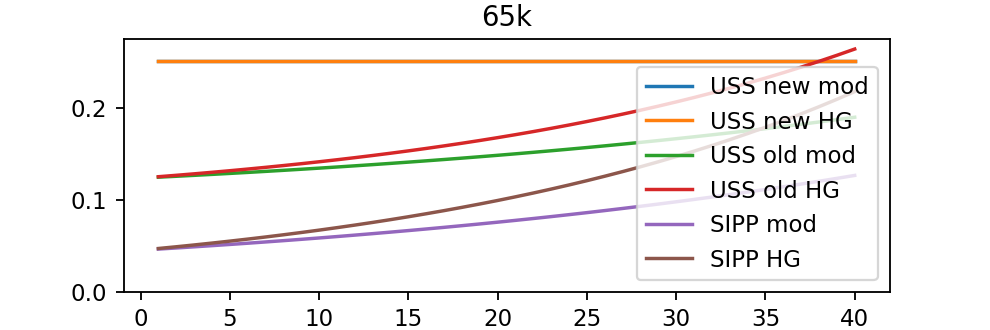

In [7]:
#40k salary
plt.figure(figsize=(6,2))
plt.title('40k')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], label='USS new')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['uss_cost_old'], label='USS old')
plt.plot(yrs, pens_40k['sipp_mod']/pens_40k['uss_cost_new'], label='SIPP mod new')
plt.plot(yrs, pens_40k['sipp_hg']/pens_40k['uss_cost_new'], label='SIPP HGg new')
plt.ylim(ymin=0)
plt.legend()

#65k salary
plt.figure(figsize=(6,2))
plt.title('65k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], label='USS new mod')
plt.plot(yrs, pens_65k['uss_new_hg']/pens_65k['uss_cost_new'], label='USS new HG')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['uss_cost_old'], label='USS old mod')
plt.plot(yrs, pens_65k['uss_old_hg']/pens_65k['uss_cost_old'], label='USS old HG')
plt.plot(yrs, pens_65k['sipp_mod']/pens_65k['uss_cost_new'], label='SIPP mod')
plt.plot(yrs, pens_65k['sipp_hg']/pens_65k['uss_cost_new'], label='SIPP HG')
plt.ylim(ymin=0)
plt.legend()

#### For USS, moderate portfolios only

<IPython.core.display.Javascript object>


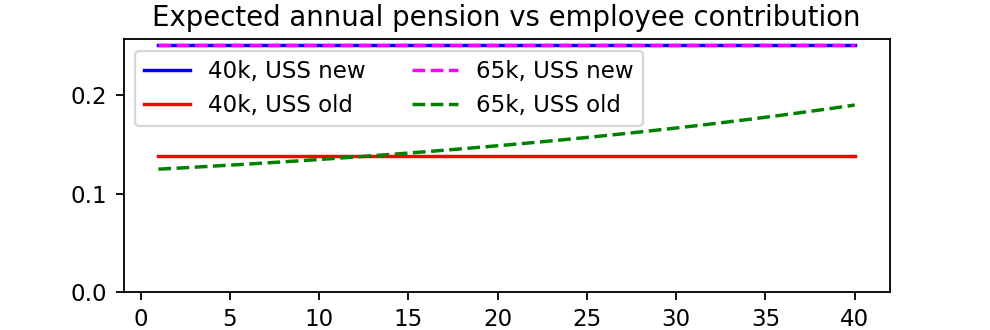

In [8]:
plt.figure(figsize=(6,2))
plt.title('Expected annual pension vs employee contribution')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], color='blue', label='40k, USS new')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['uss_cost_old'], color='red', label='40k, USS old')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], color='magenta', linestyle='--', label='65k, USS new')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['uss_cost_old'], color='green', linestyle='--', label='65k, USS old')
plt.ylim(ymin=0)
plt.legend(ncols=2)

#### For proposed USS scheme only
Using full scheme with 40k salary to represent DB pension, and showing the expected DC pension with the same contribution with moderate and 100% stocks portfolios.

In [9]:
fig=plt.figure(figsize=(6,2.5))
plt.title('Expected pension from proposed USS defined benefit (DB) and\ndefined contribution (DC) schemes as fraction of annual contribution')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], color='red', label='DB')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_mod']/pens_65k['uss_cost_new'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_hg']/pens_65k['uss_cost_new'], color='green', label='DC (100% stocks)')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
fig.subplots_adjust(top=0.8, bottom=0.2)

<IPython.core.display.Javascript object>

##### With derisking in decade before retirement

<IPython.core.display.Javascript object>


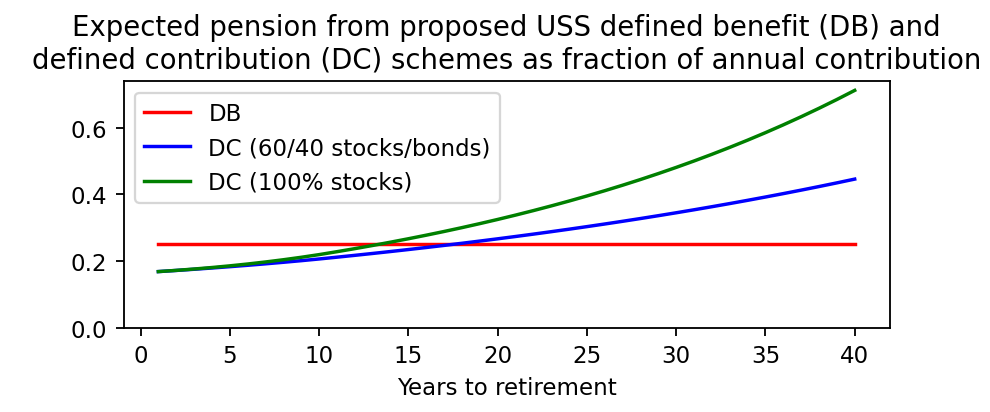

In [10]:
fig=plt.figure(figsize=(6,2.5))
plt.title('Expected pension from proposed USS defined benefit (DB) and\ndefined contribution (DC) schemes as fraction of annual contribution')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], color='red', label='DB')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_mod_dr']/pens_65k['uss_cost_new'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_hg_dr']/pens_65k['uss_cost_new'], color='green', label='DC (100% stocks)')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
fig.subplots_adjust(top=0.8, bottom=0.2)

### Pension values as ratio of cost vs salary
For moderate portfolios

<IPython.core.display.Javascript object>


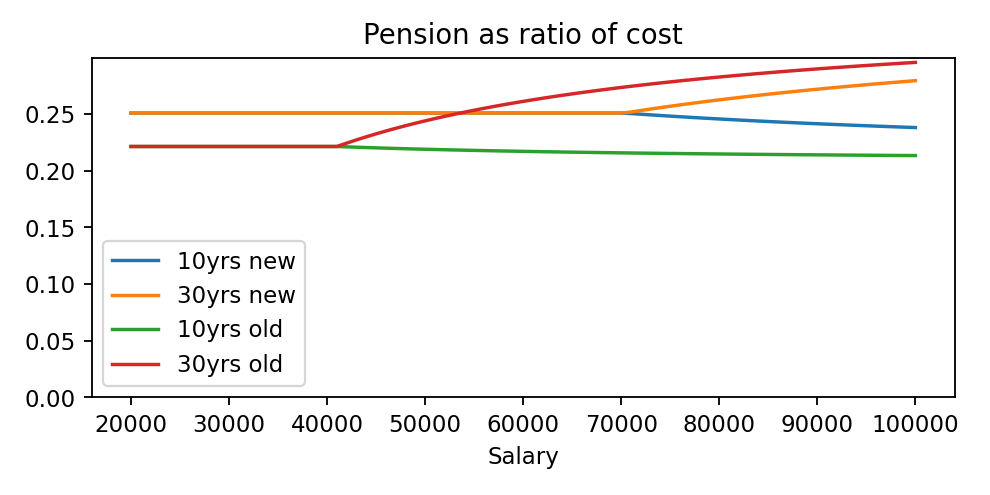

In [11]:
plt.figure(figsize=(6,3))
plt.title('Pension as ratio of cost')
plt.plot(salaries, pens_10yrs['uss_new_mod']/pens_cost_new, label='10yrs new')
plt.plot(salaries, pens_30yrs['uss_new_mod']/pens_cost_new, label='30yrs new')
plt.plot(salaries, pens_10yrs['uss_old_mod']/pens_cost_new, label='10yrs old')
plt.plot(salaries, pens_30yrs['uss_old_mod']/pens_cost_new, label='30yrs old')
plt.ylim(ymin=0)
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

### Ratios to SIPP vs time to retirement


#### For DB and DC scheme components
Using 40k salary pension values for DB scheme

In [12]:
plt.figure(figsize=(6,3))
plt.title('New USS vs SIPP')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_mod'], label='DB')
plt.plot(yrs, pens_40k['uss_new_dc_equiv_mod']/pens_40k['sipp_mod'], label='DC expected annuity')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>

#### For all salaries and new and current schemes

<IPython.core.display.Javascript object>


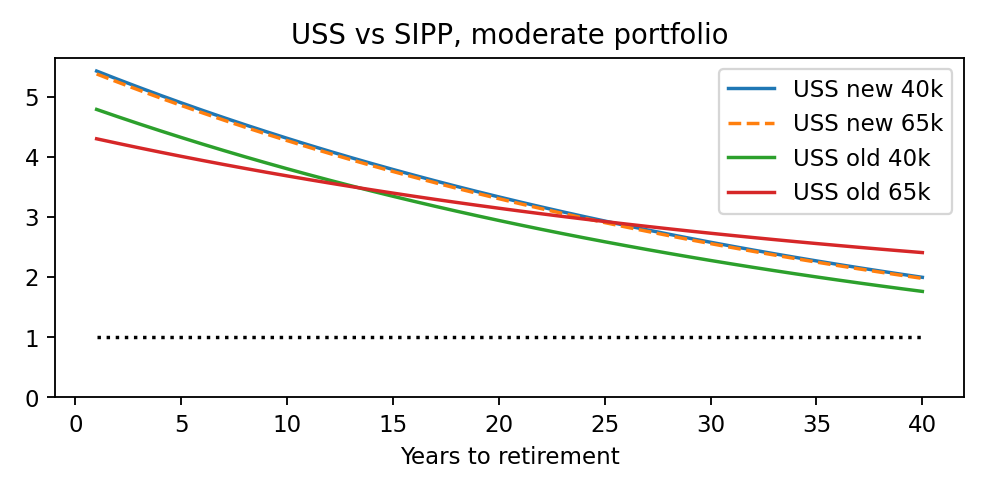

<IPython.core.display.Javascript object>


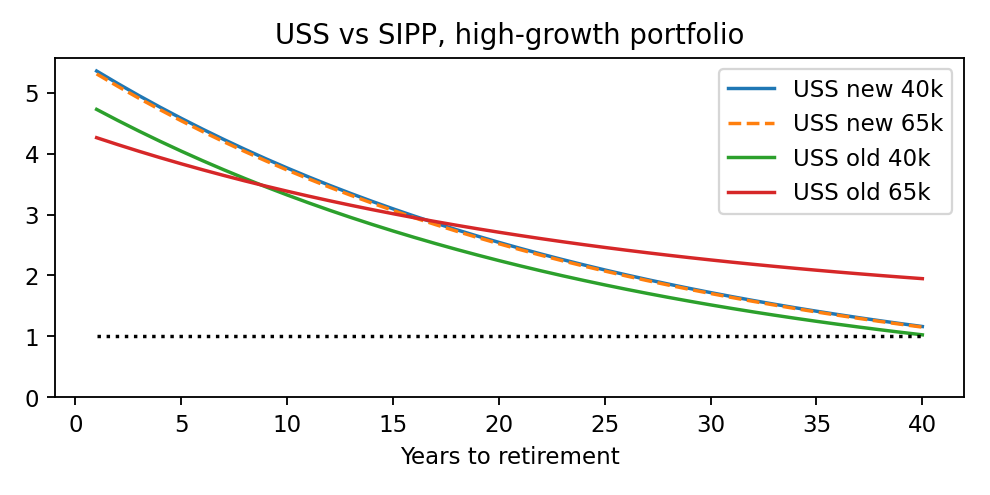

In [13]:
plt.figure(figsize=(6,3))
plt.title('USS vs SIPP, moderate portfolio')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_mod'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['sipp_mod'], '--', label='USS new 65k')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['sipp_mod'], label='USS old 40k')
plt.plot(yrs, pens_65k['uss_old_mod']/pens_65k['sipp_mod'], label='USS old 65k')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('Years to retirement')
plt.tight_layout()

plt.figure(figsize=(6,3))
plt.title('USS vs SIPP, high-growth portfolio')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['sipp_hg'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_hg']/pens_65k['sipp_hg'], '--', label='USS new 65k')
plt.plot(yrs, pens_40k['uss_old']/pens_40k['sipp_hg'], label='USS old 40k')
plt.plot(yrs, pens_65k['uss_old_hg']/pens_65k['sipp_hg'], label='USS old 65k')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.ylim(ymin=0)
plt.legend()
plt.xlabel('Years to retirement')
plt.tight_layout()


### Ratio vs DC scheme
Using 40k salary pension values for DB scheme

<IPython.core.display.Javascript object>


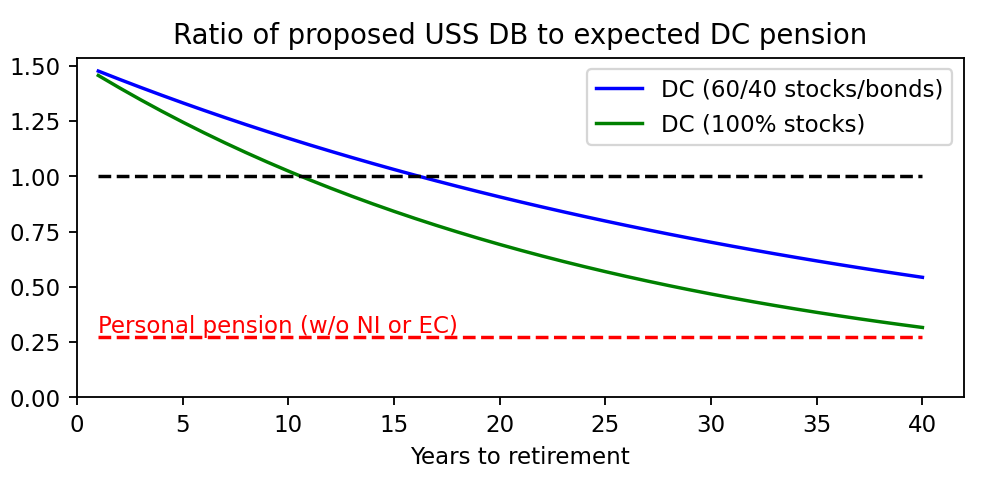

In [14]:
#For moderate portfolio
sipp_vs_dc_mod=pens_40k['sipp_mod']/pens_40k['uss_new_dc_equiv_mod']  #should be the same for 100% stocks portfolio - verified below
plt.figure(figsize=(6,3))
plt.title('Ratio of proposed USS DB to expected DC pension')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_mod'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_hg'], color='green', label='DC (100% stocks)')
plt.plot(yrs, sipp_vs_dc_mod, 'red', linestyle='--')
plt.text(yrs[0],sipp_vs_dc_mod[0],'Personal pension (w/o NI or EC)', verticalalignment='bottom', color='red')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle='--')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
plt.tight_layout()

In [15]:
#Checking that ratio for personal pension is the same for both moderate and high-growth portfolios (as it should be as it should just depend on the contribution rates and tax benefits)
sipp_vs_dc_hg=pens_40k['sipp_hg']/pens_40k['uss_new_dc_equiv_hg']
print(sipp_vs_dc_mod[[0,-1]],sipp_vs_dc_hg[[0,-1]])

[0.27174908 0.27174908] [0.27174908 0.27174908]


#### With derisking in decade before retirement

<IPython.core.display.Javascript object>


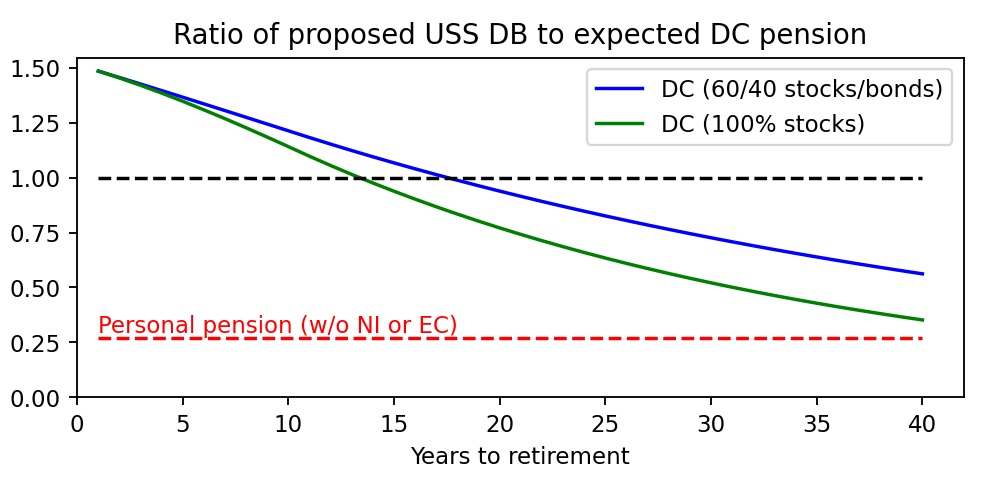

In [16]:
sipp_vs_dc_mod=pens_40k['sipp_mod_dr']/pens_40k['uss_new_dc_equiv_mod_dr']
plt.figure(figsize=(6,3))
plt.title('Ratio of proposed USS DB to expected DC pension')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_mod_dr'], color='blue', label='DC (60/40 stocks/bonds)')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_new_dc_equiv_hg_dr'], color='green', label='DC (100% stocks)')
plt.plot(yrs, sipp_vs_dc_mod, 'red', linestyle='--')
plt.text(yrs[0],sipp_vs_dc_mod[0],'Personal pension (w/o NI or EC)', verticalalignment='bottom', color='red')
plt.plot(yrs,[1]*len(yrs), 'black', linestyle='--')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()
plt.tight_layout()

### New vs old scheme as function of salary
For 10 and 30 years to retirement

<IPython.core.display.Javascript object>


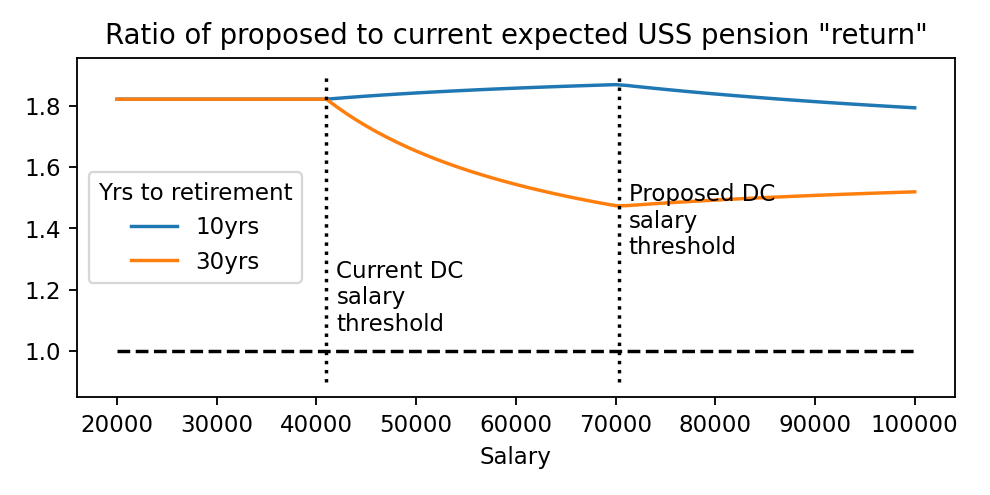

<IPython.core.display.Javascript object>


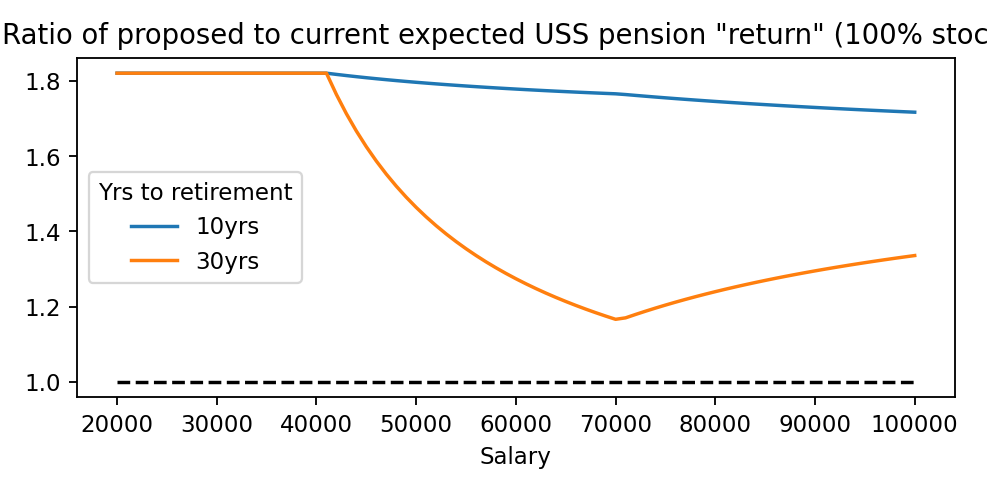

In [17]:
#Moderate portfolio
ratio_10_mod = (pens_10yrs['uss_new_mod']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_mod = (pens_30yrs['uss_new_mod']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"')
plt.plot(salaries, ratio_10_mod, label='10yrs')
plt.plot(salaries, ratio_30_mod, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_10_mod,ratio_30_mod])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.05, 'Current DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'Proposed DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

#High-growth portfolio
ratio_10_hg = (pens_10yrs['uss_new_hg']/pens_cost_new)/(pens_10yrs['uss_old_hg']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_hg = (pens_30yrs['uss_new_hg']/pens_cost_new)/(pens_30yrs['uss_old_hg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return" (100% stocks)')
plt.plot(salaries, ratio_10_hg, label='10yrs')
plt.plot(salaries, ratio_30_hg, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

#### Showing results for moderate and high-growth portfolios on the same axes

<IPython.core.display.Javascript object>


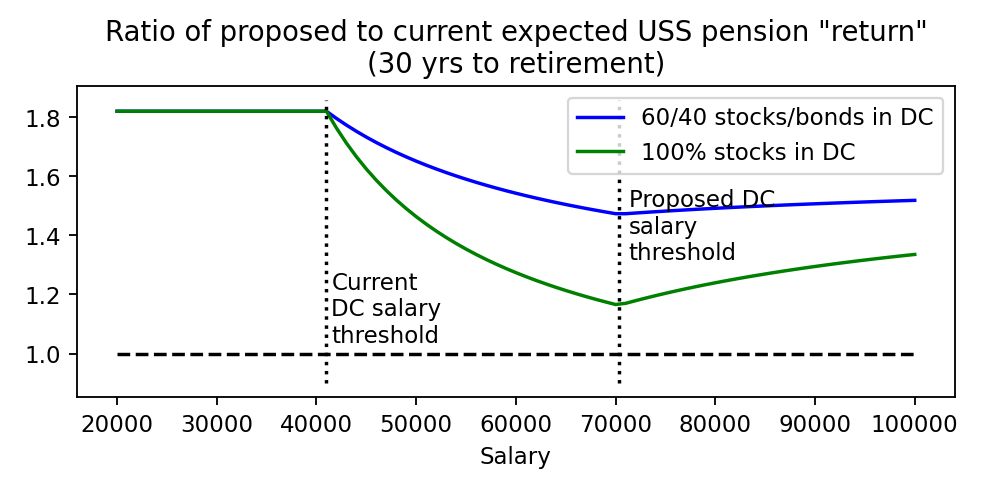

<IPython.core.display.Javascript object>


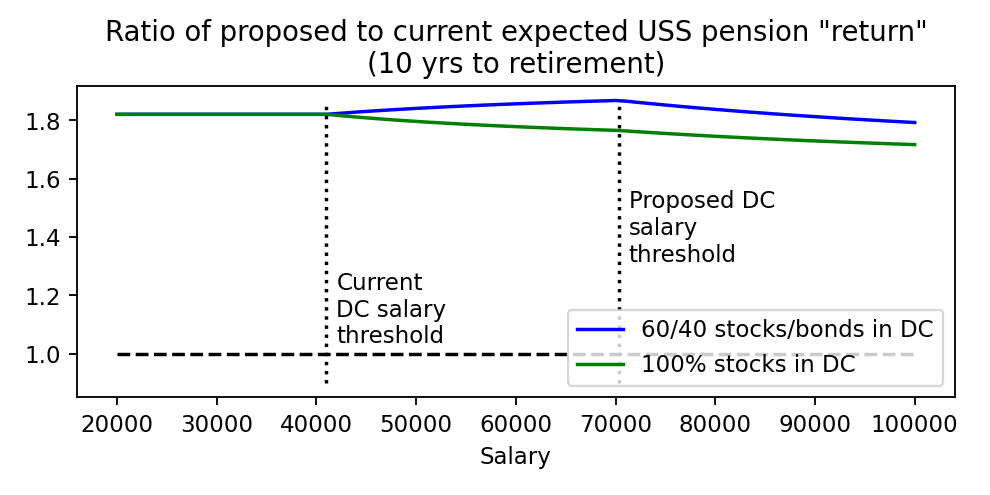

In [18]:
#30yrs to retirement
ratio_30_mod = (pens_30yrs['uss_new_mod']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old) #ratio of new and old pensions as proportion of cost
ratio_30_hg = (pens_30yrs['uss_new_hg']/pens_cost_new)/(pens_30yrs['uss_old_hg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"\n(30 yrs to retirement)')
plt.plot(salaries, ratio_30_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_30_hg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_30_mod,ratio_30_hg])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+500, 1.02, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'Proposed DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

#10 yrs to retirement
ratio_10_mod = (pens_10yrs['uss_new_mod']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  
ratio_10_hg = (pens_10yrs['uss_new_hg']/pens_cost_new)/(pens_10yrs['uss_old_hg']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"\n(10 yrs to retirement)')
plt.plot(salaries, ratio_10_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_10_hg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.02, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'Proposed DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(loc="lower right")
plt.tight_layout()

##### With derisking in decade before retirement

<IPython.core.display.Javascript object>


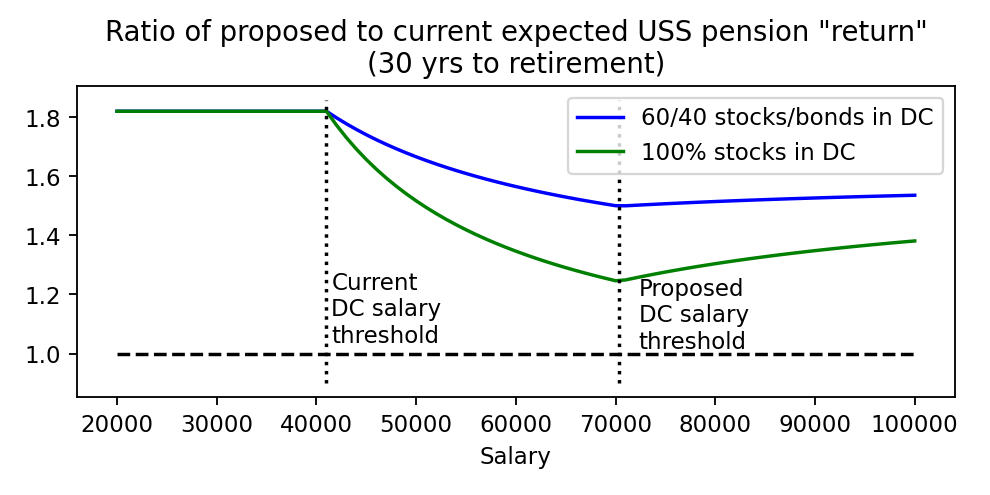

/tmp/ipykernel_128307/2159747548.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6,3))


<IPython.core.display.Javascript object>


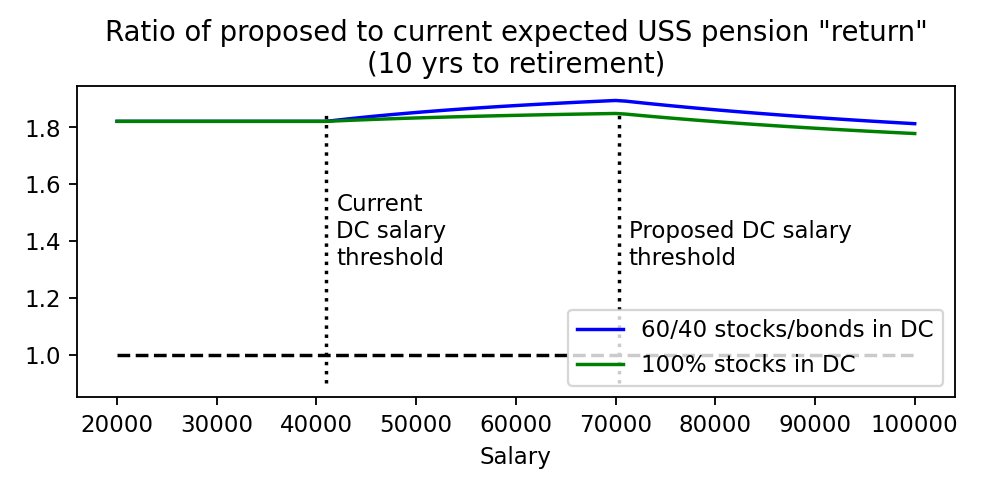

In [19]:
#30yrs to retirement
ratio_30_mod = (pens_30yrs['uss_new_mod_dr']/pens_cost_new)/(pens_30yrs['uss_old_mod_dr']/pens_cost_old) #ratio of new and old pensions as proportion of cost
ratio_30_hg = (pens_30yrs['uss_new_hg_dr']/pens_cost_new)/(pens_30yrs['uss_old_hg_dr']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"\n(30 yrs to retirement)')
plt.plot(salaries, ratio_30_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_30_hg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_30_mod,ratio_30_hg])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+500, 1.02, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+2000, 1.0, 'Proposed\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

#10 yrs to retirement
ratio_10_mod = (pens_10yrs['uss_new_mod_dr']/pens_cost_new)/(pens_10yrs['uss_old_mod_dr']/pens_cost_old)  
ratio_10_hg = (pens_10yrs['uss_new_hg_dr']/pens_cost_new)/(pens_10yrs['uss_old_hg_dr']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"\n(10 yrs to retirement)')
plt.plot(salaries, ratio_10_mod, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_10_hg, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.3, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.3, 'Proposed DC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(loc="lower right")
plt.tight_layout()

### Time-adjusting the DB payout (scaling by expected investment return)

For moderate portfolio unless otherwise stated

#### Pension values as ratio of cost vs years to retirement 

<IPython.core.display.Javascript object>


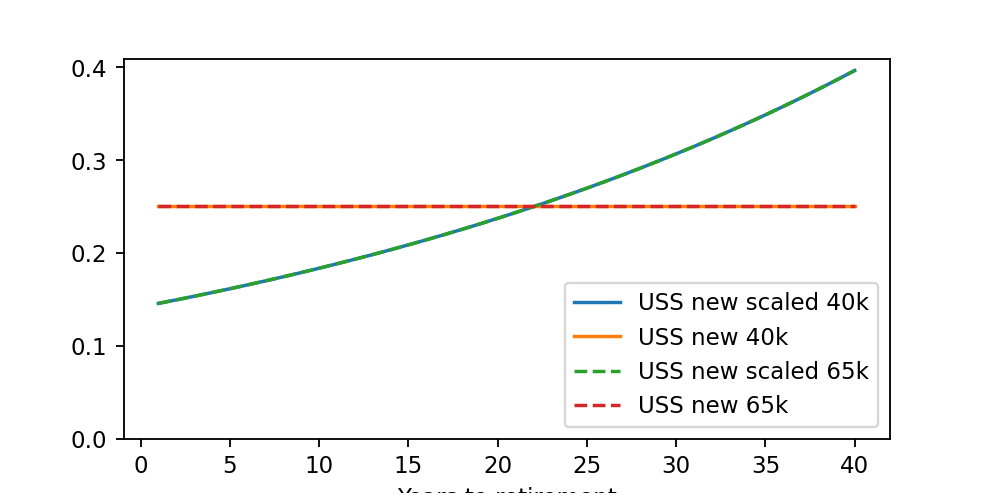

In [20]:
plt.figure(figsize=(6,3))
plt.plot(yrs, pens_40k['uss_new_db_scaled_mod']/pens_40k['uss_cost_new'], label='USS new scaled 40k')
plt.plot(yrs, pens_40k['uss_new']/pens_40k['uss_cost_new'], label='USS new 40k')
plt.plot(yrs, pens_65k['uss_new_db_scaled_mod']/pens_65k['uss_cost_new'], linestyle='--', label='USS new scaled 65k')
plt.plot(yrs, pens_65k['uss_new_mod']/pens_65k['uss_cost_new'], linestyle='--', label='USS new 65k')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

#### Pension values as ratio of cost vs salary

<IPython.core.display.Javascript object>


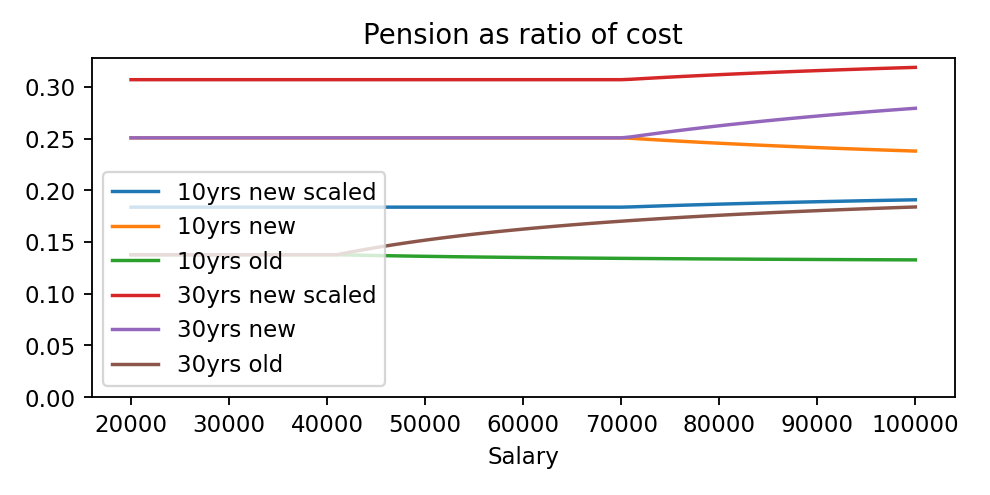

In [21]:
plt.figure(figsize=(6,3))
plt.title('Pension as ratio of cost')
plt.plot(salaries, pens_10yrs['uss_new_mod_scaled']/pens_cost_new, label='10yrs new scaled')
plt.plot(salaries, pens_10yrs['uss_new_mod']/pens_cost_new, label='10yrs new')
plt.plot(salaries, pens_10yrs['uss_old_mod']/pens_cost_old, label='10yrs old')
plt.plot(salaries, pens_30yrs['uss_new_mod_scaled']/pens_cost_new, label='30yrs new scaled')
plt.plot(salaries, pens_30yrs['uss_new_mod']/pens_cost_new, label='30yrs new')
plt.plot(salaries, pens_30yrs['uss_old_mod']/pens_cost_old, label='30yrs old')
plt.ylim(ymin=0)
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()

#### Ratio wrt DC pension

<IPython.core.display.Javascript object>


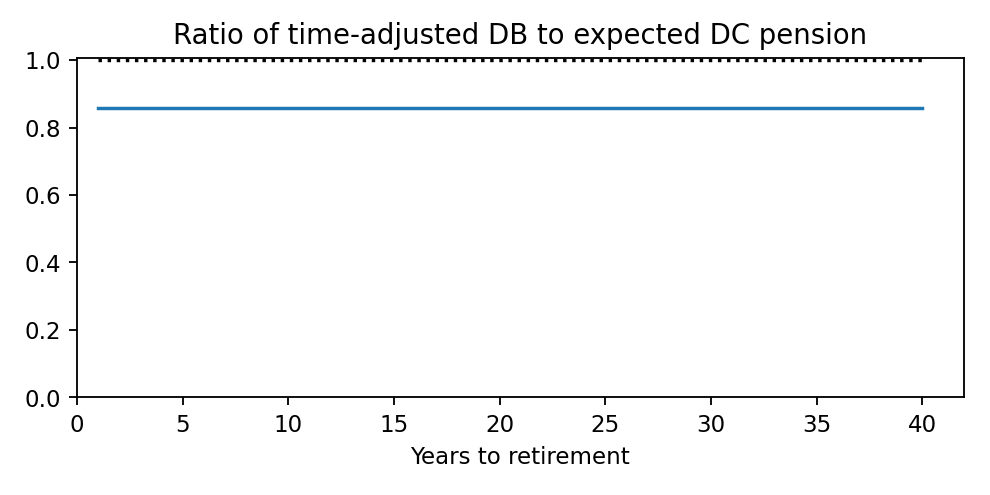

0.8588352047660757 0.858835204766076


In [22]:
#Just showing for 40k salary, as this is representative of any salary below the salary threshold
uss_new_db_scaled_mod_vs_dc=pens_40k['uss_new_db_scaled_mod']/pens_40k['uss_new_dc_equiv_mod']
plt.figure(figsize=(6,3))
plt.title('Ratio of time-adjusted DB to expected DC pension')
plt.plot(yrs, uss_new_db_scaled_mod_vs_dc)
plt.plot(yrs,[1]*len(yrs), 'black', linestyle=':')
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.tight_layout()
print(min(uss_new_db_scaled_mod_vs_dc),max(uss_new_db_scaled_mod_vs_dc))

For high-growth (100% stocks) portfolio:

In [23]:
uss_new_db_scaled_hg_vs_dc=pens_40k['uss_new_db_scaled_hg']/pens_40k['uss_new_dc_equiv_hg']
print(min(uss_new_db_scaled_hg_vs_dc),max(uss_new_db_scaled_hg_vs_dc))

0.6161090175730041 0.6161090175730044


These ratios are constant and less than 1: the difference is the price to pay for a secure retirement income.

#### New vs old scheme as function of salary

##### For moderate portfolios

<IPython.core.display.Javascript object>


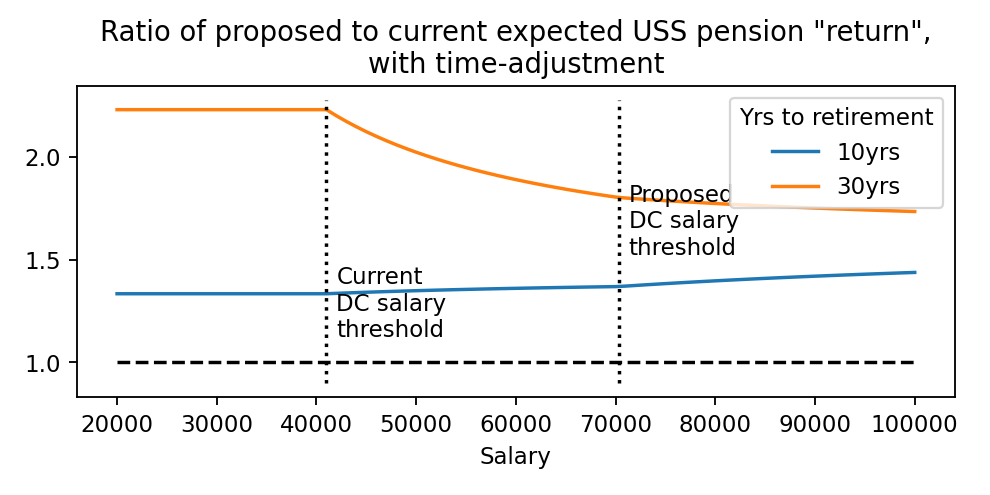

In [24]:
ratio_10_mod_scaled = (pens_10yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_10yrs['uss_old_mod']/pens_cost_old)  #ratio of new and old pensions as proportion of cost
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)

plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return",\nwith time-adjustment')
plt.plot(salaries, ratio_10_mod_scaled, label='10yrs')
plt.plot(salaries, ratio_30_mod_scaled, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_10_mod_scaled,ratio_30_mod_scaled])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+1000, 1.1, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.5, 'Proposed\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

##### At 30 yrs to retirement

<IPython.core.display.Javascript object>


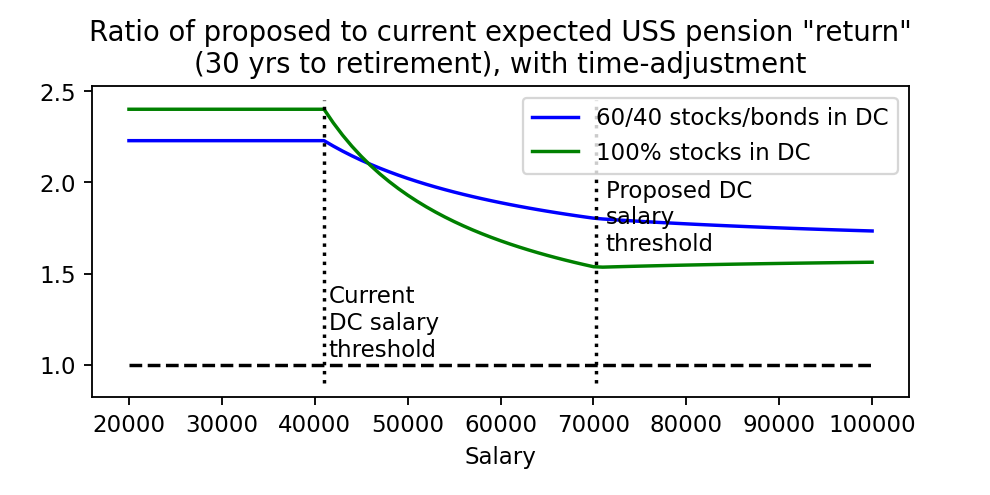

In [25]:
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_old_mod']/pens_cost_old)
ratio_30_hg_scaled = (pens_30yrs['uss_new_hg_scaled']/pens_cost_new)/(pens_30yrs['uss_old_hg']/pens_cost_old)

fig=plt.figure(figsize=(6,3))
plt.title('Ratio of proposed to current expected USS pension "return"\n(30 yrs to retirement), with time-adjustment')
plt.plot(salaries, ratio_30_mod_scaled, color='blue', label='60/40 stocks/bonds in DC')
plt.plot(salaries, ratio_30_hg_scaled, color='green', label='100% stocks in DC')
plt.plot(salaries,[1]*len(salaries),'k--')
ymax=np.max([ratio_30_mod_scaled,ratio_30_hg_scaled])
plt.plot([uss_old['sal_thres'],uss_old['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_old['sal_thres']+500, 1.02, 'Current\nDC salary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [0.9,ymax*1.02], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 1.6, 'Proposed DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend()
plt.tight_layout()
fig.subplots_adjust(right=0.92)

I think the decline above the old salary threshold here is due to the expected pension from the old scheme rising from here (see "Pension values as ratio of cost vs salary"), providing more per marginal unit of input than the scaled DB scheme (see "Ratio wrt DC pension" just above here), so the ratio decreases towards 1. Above the new salary threshold, in both cases it's the DC scheme that's being added to, so the ratio stays fairly steady and should tend to the ratio of contributions (0.098/0.061=1.61).

I think removing that dip would require lowering the DC salary threshold.

#### USS with vs without DB time-adjustment as function of salary

<IPython.core.display.Javascript object>


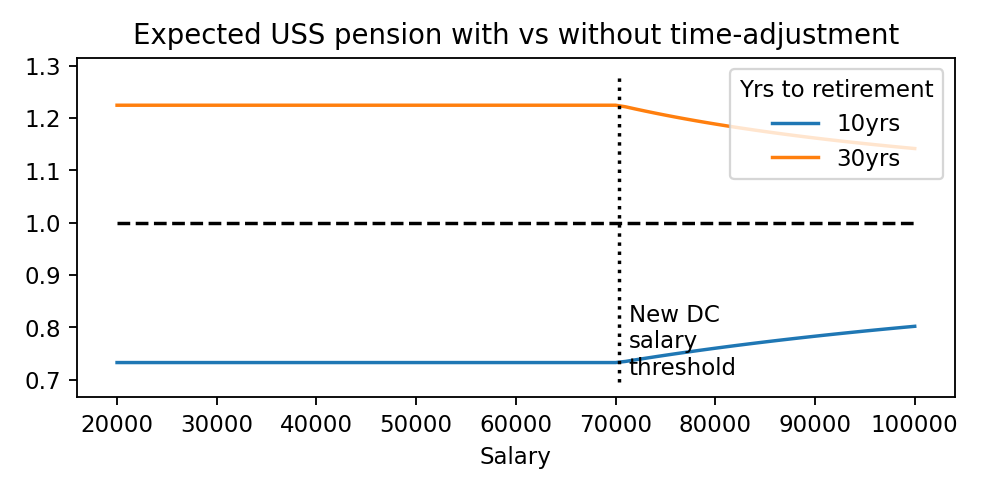

In [26]:
ratio_10_mod_scaled = (pens_10yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_10yrs['uss_new_mod']/pens_cost_new)  #ratio of new and old pensions as proportion of cost
ratio_30_mod_scaled = (pens_30yrs['uss_new_mod_scaled']/pens_cost_new)/(pens_30yrs['uss_new_mod']/pens_cost_new)

plt.figure(figsize=(6,3))
plt.title('Expected USS pension with vs without time-adjustment')
plt.plot(salaries, ratio_10_mod_scaled, label='10yrs')
plt.plot(salaries, ratio_30_mod_scaled, label='30yrs')
plt.plot(salaries,[1]*len(salaries),'k--')
ymin=np.min([ratio_10_mod_scaled,ratio_30_mod_scaled])
ymax=np.max([ratio_10_mod_scaled,ratio_30_mod_scaled])
plt.plot([uss_new['sal_thres'],uss_new['sal_thres']], [ymin*0.95,ymax*1.05], 'black', linestyle=':')
plt.text(uss_new['sal_thres']+1000, 0.7, 'New DC\nsalary\nthreshold', horizontalalignment='left', verticalalignment='bottom')
plt.xlabel('Salary')
plt.legend(title='Yrs to retirement')
plt.tight_layout()

## Some tests of the functions

2.7918651078986976 2.7918651078986976
4.801020627936657 4.801020627936657
1.2207942364867936 1.2207942364867936


<IPython.core.display.Javascript object>


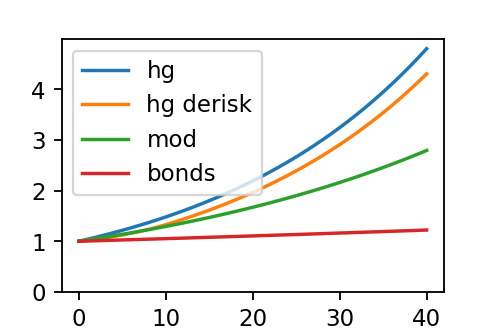

In [27]:
yrs=np.arange(41)
investment_value_mod = investment_value(port_mod,yrs)
investment_value_hg = investment_value(port_hg,yrs)
port_bonds={'eq':0., 'bonds':1.0, 'cash': 0.}
investment_value_bonds = investment_value(port_bonds, yrs)

print(investment_value_mod[-1], (1+port_mod['eq']*eq_exp_growth+port_mod['bonds']*bonds_exp_growth)**yrs[-1])
print(investment_value_hg[-1], (1+eq_exp_growth)**yrs[-1])
print(investment_value_bonds[-1], (1+bonds_exp_growth)**yrs[-1])

#Check effect of derisking for high-growth portfolio - curve should come out slightly below that calculated above
investment_value_hg_dr = investment_value(port_hg,yrs,derisk=True)

plt.figure(figsize=(3,2))
plt.plot(investment_value_hg, label='hg')
plt.plot(investment_value_hg_dr, label='hg derisk')
plt.plot(investment_value_mod, label='mod')
plt.plot(investment_value_bonds, label='bonds')
plt.ylim(ymin=0)
plt.legend()



In [28]:
print(uss_ls(uss_new), 3/75.*annuity_yield)
print(uss_ls(uss_old), 3/85.*annuity_yield)

0.00196 0.00196
0.0017294117647058823 0.0017294117647058823


0.1368013902870362 0.1368013902870362
0.23525001076889618 0.23525001076889618
0.05981891758785289 0.05981891758785289

0.08917837837837839 0.08917837837837839

0.012199726145705532
0.020979214473866213
0.005334554066834579


<IPython.core.display.Javascript object>


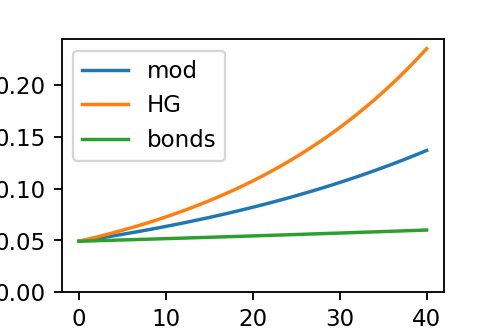

<IPython.core.display.Javascript object>


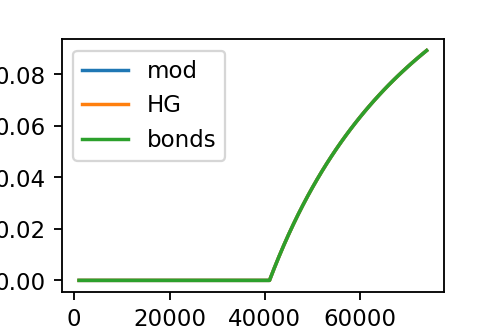

<IPython.core.display.Javascript object>


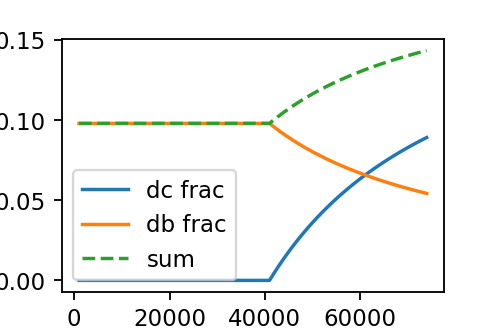

<IPython.core.display.Javascript object>


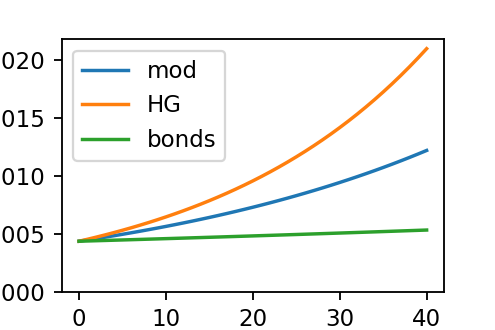

<IPython.core.display.Javascript object>


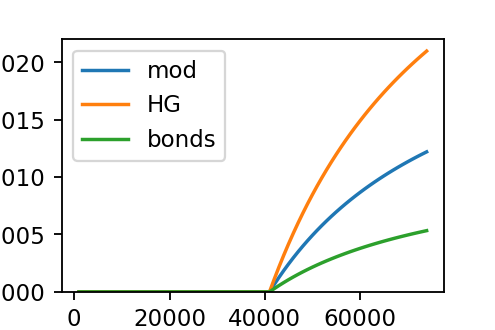

In [29]:
salaries=np.arange(1,75)*1000

uss_pens_dc_mod = np.zeros((len(salaries), len(yrs)))
dc_frac_mod = np.zeros((len(salaries), len(yrs)))
uss_pens_dc_hg = np.zeros((len(salaries), len(yrs)))
dc_frac_hg = np.zeros((len(salaries), len(yrs)))
uss_pens_dc_bonds = np.zeros((len(salaries), len(yrs)))
dc_frac_bonds = np.zeros((len(salaries), len(yrs)))

db_frac=np.zeros((len(salaries),))

for i,sal in enumerate(salaries):
    uss_pens_dc_mod[i], dc_frac_mod[i] = uss_dc(uss_old,sal,port_mod,yrs)
    uss_pens_dc_hg[i], dc_frac_hg[i] = uss_dc(uss_old,sal,port_hg,yrs)
    uss_pens_dc_bonds[i], dc_frac_bonds[i] = uss_dc(uss_old,sal,port_bonds,yrs)
    db_frac[i]=uss_db_frac(uss_old,sal)

assert np.all(uss_pens_dc_mod[:,-1]==uss_pens_dc_mod[0,-1])
assert np.all(uss_pens_dc_hg[:,-1]==uss_pens_dc_hg[0,-1])
assert np.all(uss_pens_dc_bonds[:,-1]==uss_pens_dc_bonds[0,-1])
print(uss_pens_dc_mod[0,-1], investment_value(port_mod,yrs[-1])*annuity_yield)
print(uss_pens_dc_hg[0,-1], investment_value(port_hg,yrs[-1])*annuity_yield)
print(uss_pens_dc_bonds[0,-1], investment_value(port_bonds,yrs[-1])*annuity_yield)

assert(np.all(dc_frac_mod==dc_frac_hg) and np.all(dc_frac_mod==dc_frac_bonds))
assert(np.all(dc_frac_mod[0,:]==dc_frac_mod[0]))
assert(np.all(dc_frac_mod[-1,:]==dc_frac_mod[-1]))
print()
print(dc_frac_mod[-1,0], (0.08+0.12)*(74000-uss_old['sal_thres'])/74000)

print()
print(uss_pens_dc_mod[-1,-1]*dc_frac_mod[-1,-1])
print(uss_pens_dc_hg[-1,-1]*dc_frac_hg[-1,-1])
print(uss_pens_dc_bonds[-1,-1]*dc_frac_bonds[-1,-1])

plt.figure(figsize=(3,2))
plt.plot(yrs, uss_pens_dc_mod[0], label='mod')
plt.plot(yrs, uss_pens_dc_hg[0], label='HG')
plt.plot(yrs, uss_pens_dc_bonds[0], label='bonds')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, dc_frac_mod[:,0], label='mod')
plt.plot(salaries, dc_frac_hg[:,0], label='HG')
plt.plot(salaries, dc_frac_bonds[:,0], label='bonds')
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, dc_frac_mod[:,0], label='dc frac')
plt.plot(salaries, db_frac, label='db frac')
plt.plot(salaries, dc_frac_mod[:,0]+db_frac, '--', label='sum')
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(yrs, uss_pens_dc_mod[-1]*dc_frac_mod[-1], label='mod')
plt.plot(yrs, uss_pens_dc_hg[-1]*dc_frac_hg[-1], label='HG')
plt.plot(yrs, uss_pens_dc_bonds[-1]*dc_frac_bonds[-1], label='bonds')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3,2))
plt.plot(salaries, uss_pens_dc_mod[:,-1]*dc_frac_mod[:,-1], label='mod')
plt.plot(salaries, uss_pens_dc_hg[:,-1]*dc_frac_hg[:,-1], label='HG')
plt.plot(salaries, uss_pens_dc_bonds[:,-1]*dc_frac_bonds[:,-1], label='bonds')
plt.ylim(ymin=0)
plt.legend()

[40000 65000]
0.015293333333333334 0.015293333333333334
0.013494117647058823 0.013494117647058823 0.013494117647058823
0.012130363076923077 0.012130363076923077
656.537232265544 656.537232265544
0.025881917718185946
0.028456414473866213 0.007477200000000001 0.020979214473866213 0.028456414473866213


<IPython.core.display.Javascript object>


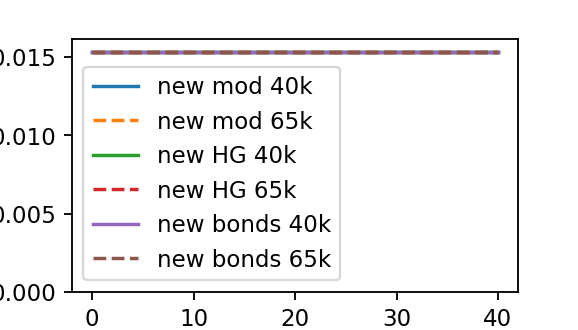

<IPython.core.display.Javascript object>


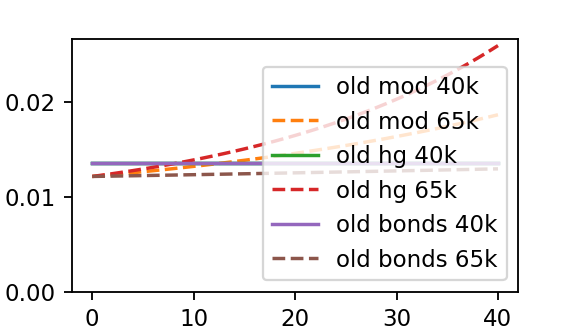

<IPython.core.display.Javascript object>


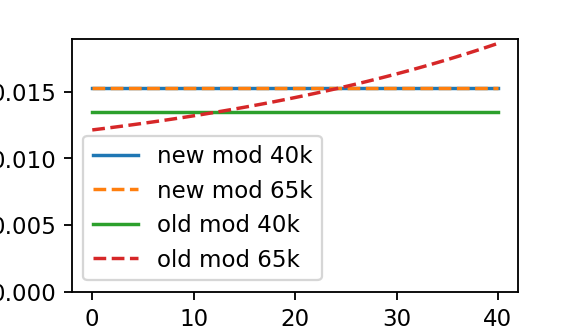

<IPython.core.display.Javascript object>


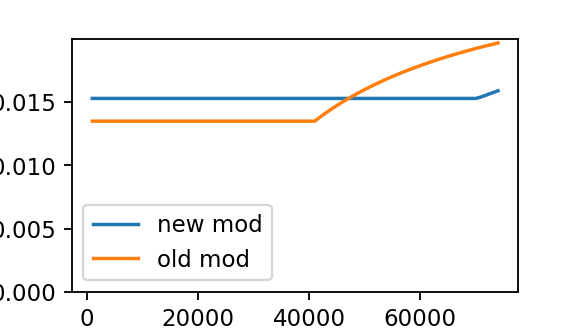

In [30]:
print(salaries[[39,64]])

uss_pens_new_mod=np.zeros((len(salaries), len(yrs)))
uss_pens_old_mod=np.zeros((len(salaries), len(yrs)))
uss_pens_new_hg=np.zeros((len(salaries), len(yrs)))
uss_pens_old_hg=np.zeros((len(salaries), len(yrs)))
uss_pens_new_bonds=np.zeros((len(salaries), len(yrs)))
uss_pens_old_bonds=np.zeros((len(salaries), len(yrs)))
for i,sal in enumerate(salaries):
    uss_pens_new_mod[i]=uss_pens(uss_new,sal,port_mod,yrs)
    uss_pens_old_mod[i]=uss_pens(uss_old,sal,port_mod,yrs)
    uss_pens_new_hg[i]=uss_pens(uss_new,sal,port_hg,yrs)
    uss_pens_old_hg[i]=uss_pens(uss_old,sal,port_hg,yrs)
    uss_pens_new_bonds[i]=uss_pens(uss_new,sal,port_bonds,yrs)
    uss_pens_old_bonds[i]=uss_pens(uss_old,sal,port_bonds,yrs)

assert np.all(uss_pens_new_mod[:65]==uss_pens_new_mod[0,0])
print(uss_pens_new_mod[0,0], 1/75.+3/75.*annuity_yield)
print(uss_pens_old_mod[39,0], uss_pens_old_mod[39,-1], 1/85.+3/85.*annuity_yield)
print(uss_pens_old_mod[64,0], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/65000 + dc_frac_mod[64,0]*uss_pens_dc_mod[64,0])  #pension as fraction of salary at 0 years until retirement is DB fraction times the salary threshold as a fraction of total salary plus the total DC contribution, with zero investment growth. 
print(uss_pens_old_mod[64,-1]*65000-uss_pens_old_mod[39,-1]*uss_old['sal_thres'], (65000-uss_old['sal_thres'])*0.2*investment_value(port_mod,yrs[-1])*annuity_yield)  #absolute pension payment (in £) coming from annuity bought from payments into DC scheme at £65k salary (i.e. total pension minus the defined benefit that applies up to the salary threshold)
print(uss_pens_old_hg[64,-1])  #should be the highest pension value plotted below
print(uss_pens_old_hg[-1,-1], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/salaries[-1], dc_frac_hg[-1,-1]*uss_pens_dc_hg[-1,-1], (1/85.+3/85.*annuity_yield)*uss_old['sal_thres']/salaries[-1] + dc_frac_hg[-1,-1]*uss_pens_dc_hg[-1,-1])  #first value should be the highest pension value in the arrays. The next values are the components and the sum to check they're equal to the first value.

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,uss_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,uss_pens_new_hg[39], label='new HG 40k')
plt.plot(yrs,uss_pens_new_hg[64], '--', label='new HG 65k')
plt.plot(yrs,uss_pens_new_bonds[39], label='new bonds 40k')
plt.plot(yrs,uss_pens_new_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,uss_pens_old_mod[64], '--', label='old mod 65k')
plt.plot(yrs,uss_pens_old_hg[39], label='old hg 40k')
plt.plot(yrs,uss_pens_old_hg[64], '--', label='old hg 65k')
plt.plot(yrs,uss_pens_old_bonds[39], label='old bonds 40k')
plt.plot(yrs,uss_pens_old_bonds[64], '--', label='old bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,uss_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,uss_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,uss_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,uss_pens_old_mod[64], '--', label='old mod 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,uss_pens_new_mod[:,-1], label='new mod')
plt.plot(salaries,uss_pens_old_mod[:,-1], label='old mod')
plt.ylim(ymin=0)
plt.legend()

<IPython.core.display.Javascript object>


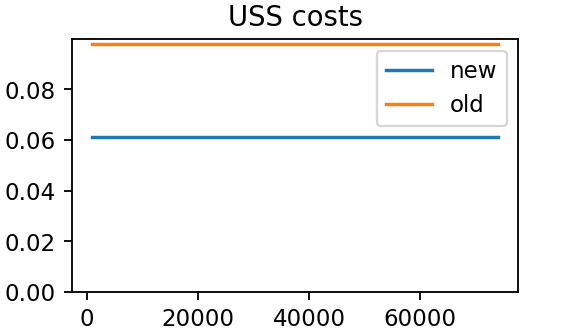

In [31]:
uss_cost_new=np.zeros((len(salaries),))
uss_cost_old=np.zeros((len(salaries),))
for i,sal in enumerate(salaries):
    uss_cost_new[i]=uss_cost(uss_new,sal)
    uss_cost_old[i]=uss_cost(uss_old,sal)

plt.figure(figsize=(3.5,2))
plt.title('USS costs')
plt.plot(salaries,uss_cost_new, label='new')
plt.plot(salaries,uss_cost_old, label='old')
plt.ylim(ymin=0)
plt.legend()    

0.028181086399129456 0.02818108639912945
0.04846150221839261 0.04846150221839261


<IPython.core.display.Javascript object>


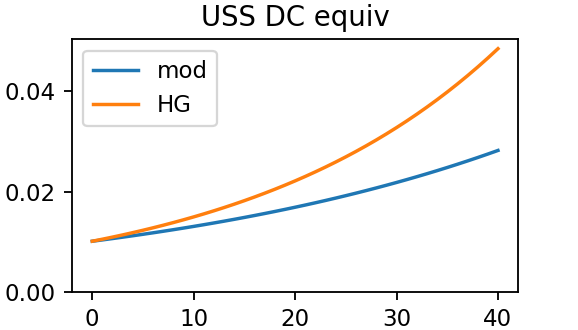

In [32]:
uss_dc_equiv_new=np.zeros((len(yrs),))
uss_dc_equiv_new_mod=uss_dc_equiv(uss_new,port_mod,yrs)
uss_dc_equiv_new_hg=uss_dc_equiv(uss_new,port_hg,yrs)

print(uss_dc_equiv_new_mod[-1], (uss_new['db_cont']+uss_new['db_empl'])*investment_value(port_mod,yrs[-1])*annuity_yield)
print(uss_dc_equiv_new_hg[-1], (uss_new['db_cont']+uss_new['db_empl'])*investment_value(port_hg,yrs[-1])*annuity_yield)

plt.figure(figsize=(3.5,2))
plt.title('USS DC equiv')
plt.plot(yrs,uss_dc_equiv_new_mod, label='mod')
plt.plot(yrs,uss_dc_equiv_new_hg, label='HG')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

<IPython.core.display.Javascript object>


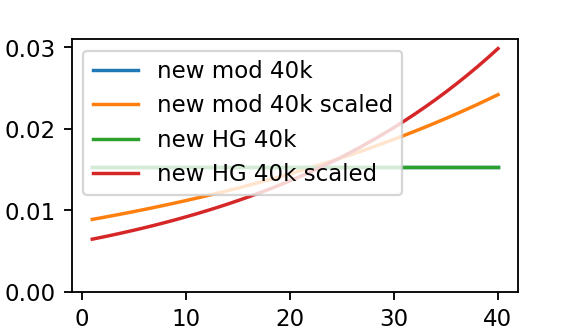

<IPython.core.display.Javascript object>


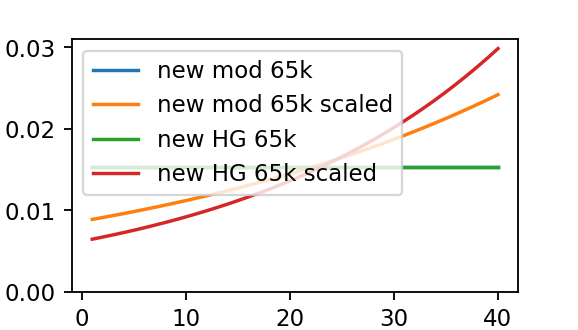

<IPython.core.display.Javascript object>


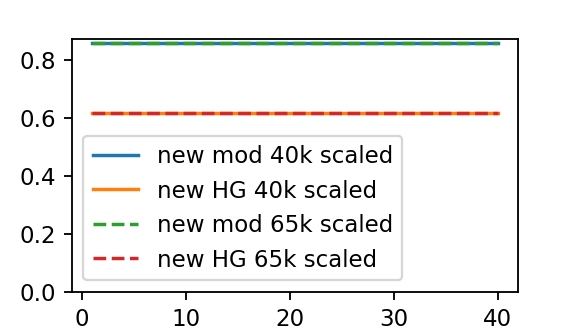

<IPython.core.display.Javascript object>


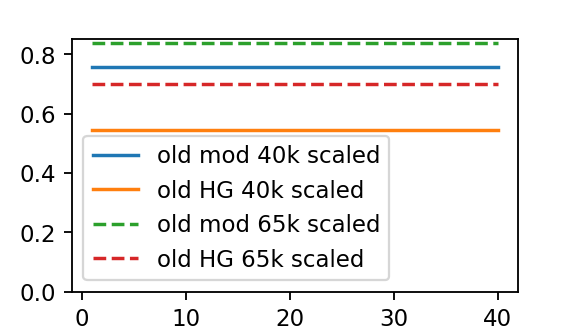

In [33]:
#Testing scaling USS pension by expected DC investment return - for arrays of years to retirement

yrs_from_1=np.arange(40)+1  #use years axis starting at 1 to match that used in normalisation in uss_pens() for scaled DB part, to enable comparison with using a single year value in the cell below
uss_pens_new_40k_mod_scaled=uss_pens(uss_new,salaries[39],port_mod,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled=uss_pens(uss_old,salaries[39],port_mod,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_40k_hg_scaled=uss_pens(uss_new,salaries[39],port_hg,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_40k_hg_scaled=uss_pens(uss_old,salaries[39],port_hg,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled=uss_pens(uss_new,salaries[64],port_mod,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled=uss_pens(uss_old,salaries[64],port_mod,yrs_from_1,scale_by_inv_return=True)
uss_pens_new_65k_hg_scaled=uss_pens(uss_new,salaries[64],port_hg,yrs_from_1,scale_by_inv_return=True)
uss_pens_old_65k_hg_scaled=uss_pens(uss_old,salaries[64],port_hg,yrs_from_1,scale_by_inv_return=True)

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_mod[39,1:], label='new mod 40k')
plt.plot(yrs_from_1,uss_pens_new_40k_mod_scaled, label='new mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_hg[39,1:], label='new HG 40k')
plt.plot(yrs_from_1,uss_pens_new_40k_hg_scaled, label='new HG 40k scaled')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_mod[64,1:], label='new mod 65k')
plt.plot(yrs_from_1,uss_pens_new_65k_mod_scaled, label='new mod 65k scaled')
plt.plot(yrs_from_1,uss_pens_new_hg[64,1:], label='new HG 65k')
plt.plot(yrs_from_1,uss_pens_new_65k_hg_scaled, label='new HG 65k scaled')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

#Plots of ratios of scaled DB pensions to DC expected pension should be flat
plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_new_40k_mod_scaled/uss_dc_equiv_new_mod[1:], label='new mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_40k_hg_scaled/uss_dc_equiv_new_hg[1:], label='new HG 40k scaled')
plt.plot(yrs_from_1,uss_pens_new_65k_mod_scaled/uss_dc_equiv_new_mod[1:], label='new mod 65k scaled', linestyle='--')
plt.plot(yrs_from_1,uss_pens_new_65k_hg_scaled/uss_dc_equiv_new_hg[1:], label='new HG 65k scaled', linestyle='--')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs_from_1,uss_pens_old_40k_mod_scaled/uss_dc_equiv_new_mod[1:], label='old mod 40k scaled')
plt.plot(yrs_from_1,uss_pens_old_40k_hg_scaled/uss_dc_equiv_new_hg[1:], label='old HG 40k scaled')
plt.plot(yrs_from_1,uss_pens_old_65k_mod_scaled/uss_dc_equiv_new_mod[1:], label='old mod 65k scaled', linestyle='--')
plt.plot(yrs_from_1,uss_pens_old_65k_hg_scaled/uss_dc_equiv_new_hg[1:], label='old HG 65k scaled', linestyle='--')
plt.ylim(ymin=0)
plt.xlabel('Years to retirement')
plt.legend()

In [34]:
#Testing scaling USS pension by expected DC investment return - for single value of years to retirement
#Check the ratio is the same as for the corresponding value in the arrays calculated with multiple years
uss_pens_new_40k_mod_scaled_10=uss_pens(uss_new,salaries[39],port_mod,10,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled_10=uss_pens(uss_old,salaries[39],port_mod,10,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled_10=uss_pens(uss_new,salaries[64],port_mod,10,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled_10=uss_pens(uss_old,salaries[64],port_mod,10,scale_by_inv_return=True)
uss_pens_new_40k_mod_scaled_30=uss_pens(uss_new,salaries[39],port_mod,30,scale_by_inv_return=True)
uss_pens_old_40k_mod_scaled_30=uss_pens(uss_old,salaries[39],port_mod,30,scale_by_inv_return=True)
uss_pens_new_65k_mod_scaled_30=uss_pens(uss_new,salaries[64],port_mod,30,scale_by_inv_return=True)
uss_pens_old_65k_mod_scaled_30=uss_pens(uss_old,salaries[64],port_mod,30,scale_by_inv_return=True)

print(yrs_from_1[9],yrs_from_1[29])  #should be 10, 30
print(uss_pens_new_40k_mod_scaled_10, uss_pens_new_40k_mod_scaled[9])
print(uss_pens_old_40k_mod_scaled_10, uss_pens_old_40k_mod_scaled[9])
print(uss_pens_new_65k_mod_scaled_10, uss_pens_new_65k_mod_scaled[9])
print(uss_pens_old_65k_mod_scaled_10, uss_pens_old_65k_mod_scaled[9])
print(uss_pens_new_40k_mod_scaled_30, uss_pens_new_40k_mod_scaled[29])
print(uss_pens_old_40k_mod_scaled_30, uss_pens_old_40k_mod_scaled[29])
print(uss_pens_new_65k_mod_scaled_30, uss_pens_new_65k_mod_scaled[29])
print(uss_pens_old_65k_mod_scaled_30, uss_pens_old_65k_mod_scaled[29])

10 30
0.011205900103628855 0.011205900103628855
0.009887558914966631 0.009887558914966631
0.011205900103628855 0.011205900103628855
0.010913922067836803 0.010913922067836803
0.018723798644944608 0.018723798644944604
0.016520998804362877 0.016520998804362873
0.018723798644944608 0.018723798644944604
0.018235936188527875 0.018235936188527875


<IPython.core.display.Javascript object>


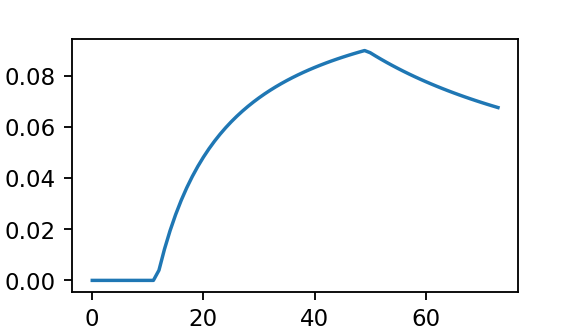

<IPython.core.display.Javascript object>


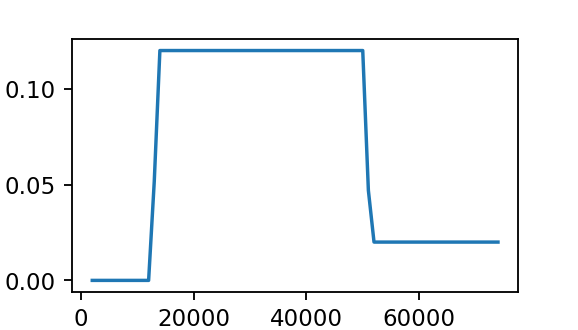

In [35]:
ni_vals=np.zeros(len(salaries))
for i,sal in enumerate(salaries):
    ni_vals[i]=ni(sal)

plt.figure(figsize=(3.5,2))
plt.plot(ni_vals)

#Should return the percentage of salary taken by NI
ni_amounts=ni_vals*salaries
ni_rates=(ni_amounts[1:]-ni_amounts[:-1])/(salaries[1:]-salaries[:-1])
plt.figure(figsize=(3.5,2))
plt.plot(salaries[1:],ni_rates)

<IPython.core.display.Javascript object>


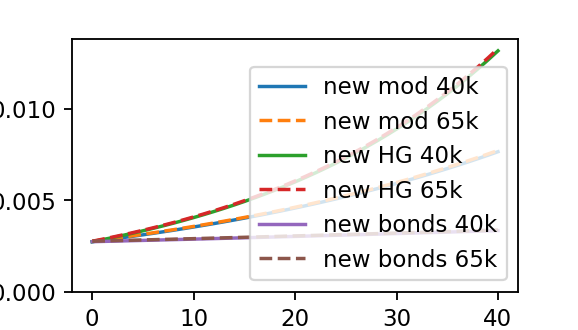

<IPython.core.display.Javascript object>


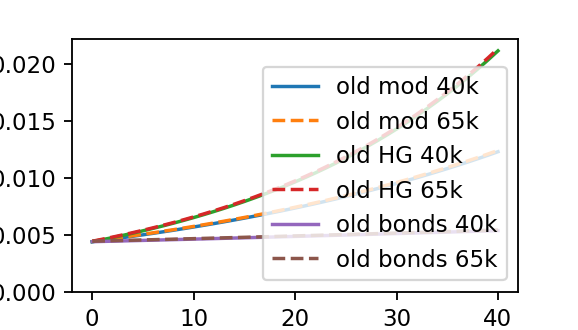

<IPython.core.display.Javascript object>


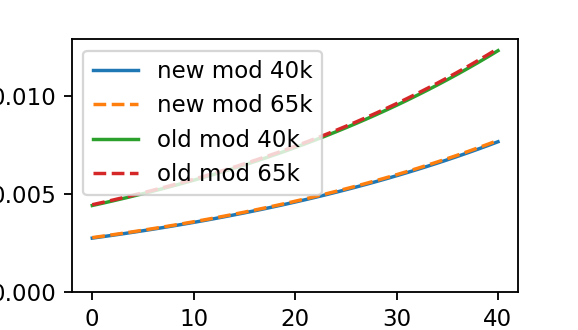

0.6224489795918368 0.6224489795918366 0.6224489795918366


<IPython.core.display.Javascript object>


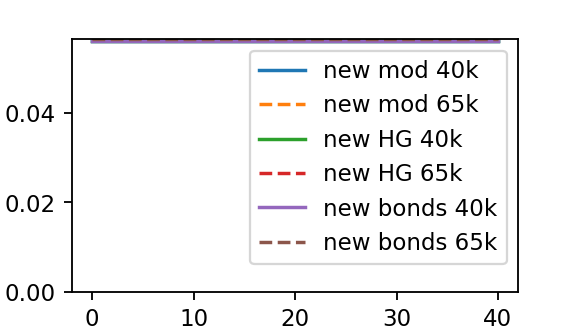

<IPython.core.display.Javascript object>


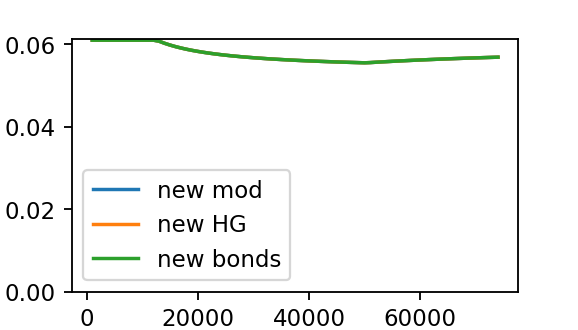

In [36]:
sipp_pens_new_mod=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_mod=np.zeros((len(salaries), len(yrs)))
sipp_pens_new_hg=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_hg=np.zeros((len(salaries), len(yrs)))
sipp_pens_new_bonds=np.zeros((len(salaries), len(yrs)))
sipp_pens_old_bonds=np.zeros((len(salaries), len(yrs)))
for i,sal in enumerate(salaries):
    sipp_pens_new_mod[i]=sipp_pens(uss_new,sal,port_mod,yrs)
    sipp_pens_old_mod[i]=sipp_pens(uss_old,sal,port_mod,yrs)
    sipp_pens_new_hg[i]=sipp_pens(uss_new,sal,port_hg,yrs)
    sipp_pens_old_hg[i]=sipp_pens(uss_old,sal,port_hg,yrs)
    sipp_pens_new_bonds[i]=sipp_pens(uss_new,sal,port_bonds,yrs)
    sipp_pens_old_bonds[i]=sipp_pens(uss_old,sal,port_bonds,yrs)

plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_new_hg[39], label='new HG 40k')
plt.plot(yrs,sipp_pens_new_hg[64], '--', label='new HG 65k')
plt.plot(yrs,sipp_pens_new_bonds[39], label='new bonds 40k')
plt.plot(yrs,sipp_pens_new_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

#Values for old scheme should be scaled up compared to above curves by ratio of contribution rates (given that 65k is below salary threshold for the new scheme)
plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,sipp_pens_old_mod[64], '--', label='old mod 65k')
plt.plot(yrs,sipp_pens_old_hg[39], label='old HG 40k')
plt.plot(yrs,sipp_pens_old_hg[64], '--', label='old HG 65k')
plt.plot(yrs,sipp_pens_old_bonds[39], label='old bonds 40k')
plt.plot(yrs,sipp_pens_old_bonds[64], '--', label='old bonds 65k')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_old_mod[39], label='old mod 40k')
plt.plot(yrs,sipp_pens_old_mod[64], '--', label='old mod 65k')
plt.ylim(ymin=0)
plt.legend()

print(sipp_pens_new_mod[39,-1]/sipp_pens_old_mod[39,-1], sipp_pens_new_mod[64,-1]/sipp_pens_old_mod[64,-1], uss_new['db_cont']/uss_old['db_cont'])


#Ratio with respect to DC value:

#should be constant with respect to time to retirement
plt.figure(figsize=(3.5,2))
plt.plot(yrs,sipp_pens_new_mod[39]/uss_pens_dc_mod[39], label='new mod 40k')
plt.plot(yrs,sipp_pens_new_mod[64]/uss_pens_dc_mod[64], '--', label='new mod 65k')
plt.plot(yrs,sipp_pens_new_hg[39]/uss_pens_dc_hg[39], label='new HG 40k')
plt.plot(yrs,sipp_pens_new_hg[64]/uss_pens_dc_hg[64], '--', label='new HG 65k')
plt.plot(yrs,sipp_pens_new_bonds[39]/uss_pens_dc_bonds[39], label='new bonds 40k')
plt.plot(yrs,sipp_pens_new_bonds[64]/uss_pens_dc_bonds[64], '--', label='new bonds 65k')
plt.ylim(ymin=0)
plt.legend()

#should drop by the NI rate as salary increases above the threshold
plt.figure(figsize=(3.5,2))
plt.plot(salaries,sipp_pens_new_mod[:,-1]/uss_pens_dc_mod[:,-1], label='new mod')
plt.plot(salaries,sipp_pens_new_hg[:,-1]/uss_pens_dc_hg[:,-1], label='new HG')
plt.plot(salaries,sipp_pens_new_bonds[:,-1]/uss_pens_dc_bonds[:,-1], label='new bonds')
plt.ylim(ymin=0)
plt.legend()

<IPython.core.display.Javascript object>


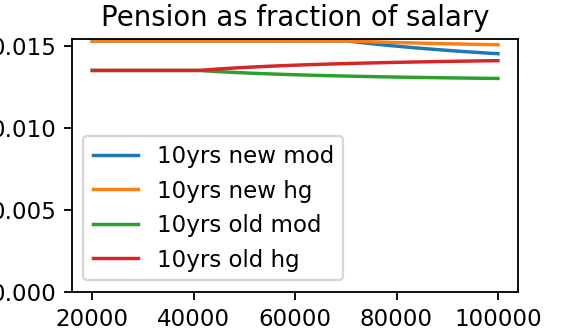

<IPython.core.display.Javascript object>


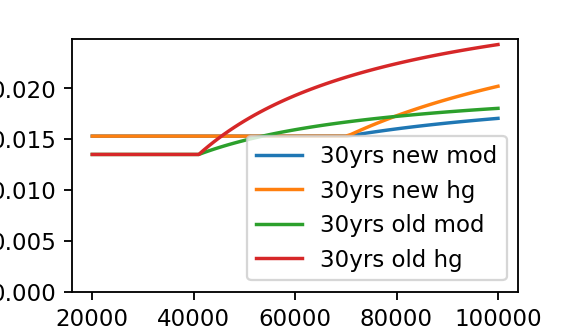

<IPython.core.display.Javascript object>


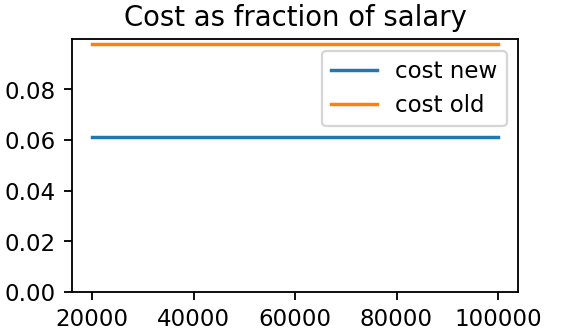

<IPython.core.display.Javascript object>


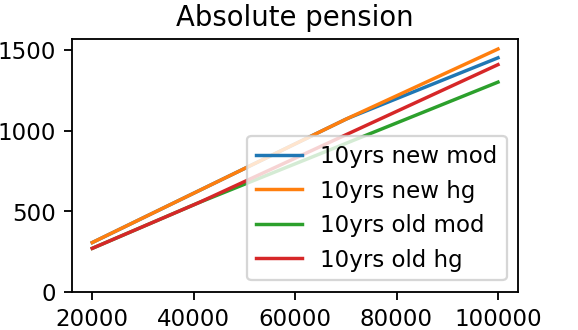

<IPython.core.display.Javascript object>


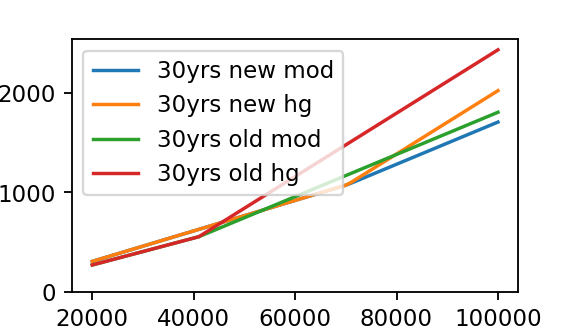

In [37]:
#Checking calculation of pension vs salary

salaries=np.arange(20,101,1)*1000

plt.figure(figsize=(3.5,2))
plt.title('Pension as fraction of salary')
plt.plot(salaries,pens_10yrs['uss_new_mod'],label='10yrs new mod')
plt.plot(salaries,pens_10yrs['uss_new_hg'],label='10yrs new hg')
plt.plot(salaries,pens_10yrs['uss_old_mod'],label='10yrs old mod')
plt.plot(salaries,pens_10yrs['uss_old_hg'],label='10yrs old hg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,pens_30yrs['uss_new_mod'],label='30yrs new mod')
plt.plot(salaries,pens_30yrs['uss_new_hg'],label='30yrs new hg')
plt.plot(salaries,pens_30yrs['uss_old_mod'],label='30yrs old mod')
plt.plot(salaries,pens_30yrs['uss_old_hg'],label='30yrs old hg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.title('Cost as fraction of salary')
plt.plot(salaries,pens_cost_new,label='cost new')
plt.plot(salaries,pens_cost_old,label='cost old')
plt.ylim(ymin=0)
plt.legend()

#Check absolute pension values (fractions multiplied by salary) are straight lines above the salary threshold
plt.figure(figsize=(3.5,2))
plt.title('Absolute pension')
plt.plot(salaries,pens_10yrs['uss_new_mod']*salaries,label='10yrs new mod')
plt.plot(salaries,pens_10yrs['uss_new_hg']*salaries,label='10yrs new hg')
plt.plot(salaries,pens_10yrs['uss_old_mod']*salaries,label='10yrs old mod')
plt.plot(salaries,pens_10yrs['uss_old_hg']*salaries,label='10yrs old hg')
plt.ylim(ymin=0)
plt.legend()

plt.figure(figsize=(3.5,2))
plt.plot(salaries,pens_30yrs['uss_new_mod']*salaries,label='30yrs new mod')
plt.plot(salaries,pens_30yrs['uss_new_hg']*salaries,label='30yrs new hg')
plt.plot(salaries,pens_30yrs['uss_old_mod']*salaries,label='30yrs old mod')
plt.plot(salaries,pens_30yrs['uss_old_hg']*salaries,label='30yrs old hg')
plt.ylim(ymin=0)
plt.legend()


In [38]:
#Checking derisking - pension values should come out as slightly lower than values without derisking (when salary is above the salary threshold for uss_pens).
uss_dc_mod=uss_dc(uss_new,100000,port_hg,40,derisk=False)[0]
uss_dc_mod_dr=uss_dc(uss_new,100000,port_hg,40,derisk=True)[0]
uss_pens_mod=uss_pens(uss_new,100000,port_hg,40,derisk=False)
uss_pens_mod_dr=uss_pens(uss_new,100000,port_hg,40,derisk=True)
uss_dc_equiv_mod=uss_dc_equiv(uss_new,port_hg,40,derisk=False)
uss_dc_equiv_mod_dr=uss_dc_equiv(uss_new,port_hg,40,derisk=True)
sipp_pens_mod=sipp_pens(uss_new,100000,port_hg,40,derisk=False)
sipp_pens_mod_dr=sipp_pens(uss_new,100000,port_hg,40,derisk=True)

print(uss_dc_mod,uss_dc_mod_dr)
print(uss_pens_mod,uss_pens_mod_dr)
print(uss_dc_equiv_mod,uss_dc_equiv_mod_dr)
print(sipp_pens_mod,sipp_pens_mod_dr)

0.23525001076889618 [0.21092014]
0.024722523439500134 [0.02327772]
0.04846150221839261 [0.04344955]
0.01355831772415084 [0.0121561]
